In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import yfinance as yf # conda install conda-forge::yfinance
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import get_cmap
from tqdm import tqdm
from scipy.stats import skewnorm
from curl_cffi import requests # pip install curl_cffi --upgrade
from sklearn.utils import resample
from scipy.stats import gaussian_kde # only for KDE estimate
from pypfopt import EfficientFrontier, risk_models # pip install PyPortfolioOpt
from pypfopt.black_litterman import BlackLittermanModel # for different solvers: <! pip install ecos osqp scs cvxopt>
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import plotting
from itertools import combinations
import zipfile
from sklearn.model_selection import train_test_split
import seaborn as sns 
import re
import DLS_model as dls
import DmNN as dmnn
import Performance_Metrics as pm 
import RNN_model as rnn_model
import MVO as mvo

In [2]:
device = [torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"]
print(f"Using {device} device")

Using ['mps'] device


## Training Data 

get data 

In [2]:
def process_zip_with_csvs(zip_path, column_extract = "Close", get_pries = False):

    # Step 1: Load and extract data from ZIP
    data_frames = []
    
    # read "r" zip file 
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # Get list of CSV files in the ZIP
        csv_files = [f for f in zip_ref.namelist() if f.endswith('.csv')]
        
        for csv_file in csv_files:
            # Read CSV directly from ZIP
            with zip_ref.open(csv_file) as f:
                df = pd.read_csv(f)
                
                # Extract close price  
                # Adjust column name as needed for your data
                if column_extract in df.columns:
                    # Create a single-column DataFrame with returns
                    temp_df = pd.DataFrame()
                    if get_pries:
                        temp_df['Prices'] = df[column_extract].dropna(how = 'any')
                    else:
                        temp_df['Returns'] = df[column_extract].pct_change().dropna(how = "any")
                    
                    # Use filename (without extension) as column name
                    asset_name = csv_file.split('/')[-1].replace('.csv', '')
                    temp_df.columns = [asset_name]
                    
                    data_frames.append(temp_df)
    
    # Step 2: Combine all DataFrames
    if not data_frames:
        raise ValueError(f"No valid CSV files with '{column_extract}' prices found in the ZIP")
    
    combined_df = pd.concat(data_frames, axis=1)
    
    # Drop any rows with NA values (that might remain after pct_change)
    combined_df = combined_df.dropna()
    
    # Step 3: Train-test split
    # Convert to numpy array (each column is an asset's return series)
    returns_array = combined_df.values
    
    # Split into training and testing sets (80-20 split)
    asset_returns, asset_returns_unseen = train_test_split(
        returns_array, 
        test_size=0.3, 
        shuffle=False  # Important for time series data
    )
    
    return combined_df, asset_returns, asset_returns_unseen

In [3]:
# Usage:
zip_path = r'/Users/amjadsaidam/Desktop/STAT0034 - Research Project/Anomaly Detection Finance Application /Ideas/Portfolio Distribution Fitting /Data /Most Watched Stocks.zip'
column = "Close"
combined_df, asset_returns, asset_returns_unseen = process_zip_with_csvs(zip_path, column_extract = column, get_pries = False)
m, n_assets = asset_returns.shape  # m = number of samples, n_assets = number of assets

In [4]:
def extract_ticker(asset_name: str) -> str:
    """
    Extracts the ticker from a string like 'NVDA(some text)'.
    Returns the cleaned ticker in uppercase.
    """
    match = re.match(r"([A-Z]+)\s*\(", asset_name.upper())
    if match:
        return match.group(1)
    raise ValueError(f"Ticker not found in: {asset_name}")

def ticker_standerdise(data):
    # insure only ticker names 
    tickers = [extract_ticker(data.columns[i]) for i in range(len(data.columns))]
    data.columns = tickers

In [5]:
ticker_standerdise(combined_df)
combined_df.head()

AAPL       AMD      AMZN      ATVI      BABA       BAC       CRM  \
1 -0.012622 -0.015810  0.004547  0.005479 -0.033495 -0.005819 -0.014372   
2 -0.027855  0.040161  0.002592  0.014532  0.010493  0.012542  0.005335   
3 -0.005882  0.030888  0.035925  0.000895  0.001334 -0.001652 -0.003714   
4  0.002691  0.000000 -0.007748 -0.016995 -0.003901 -0.009098  0.005859   
5 -0.015629 -0.014981 -0.000113 -0.004550  0.010220 -0.045910  0.010943   

       CSCO       DIS        EA  ...      NVDA       PFE      PYPL         T  \
1  0.005408  0.002153  0.013058  ...  0.000786 -0.002316 -0.052430  0.000571   
2  0.001467  0.019137  0.009498  ...  0.032993  0.004255 -0.005764  0.005997   
3 -0.009277 -0.023376 -0.028898  ... -0.028897  0.000770  0.005507  0.004542   
4  0.000986 -0.004120 -0.047059  ... -0.021926  0.001540  0.060248 -0.029387   
5 -0.000492  0.000394 -0.005084  ... -0.022418  0.017294  0.004078 -0.003202   

       TSLA       TTD       WMT       XOM      YELP        ZG  
1 -0.016685 -0.042907 -0.006355 -0.001804  0.022843  0.011307  
2 -0.010642  0.003977  0.003779  0.004630  0.067990  0.034242  
3 -0.001744  0.079582 -0.009557 -0.011578 -0.020446  0.067568  
4 -0.019220  0.113742  0.002778  0.006255 -0.011860  0.016456  
5 -0.001187 -0.131776 -0.000292 -0.003843 -0.003361 -0.019614  

[5 rows x 30 columns]

In [6]:
tickers = combined_df.columns.to_list()

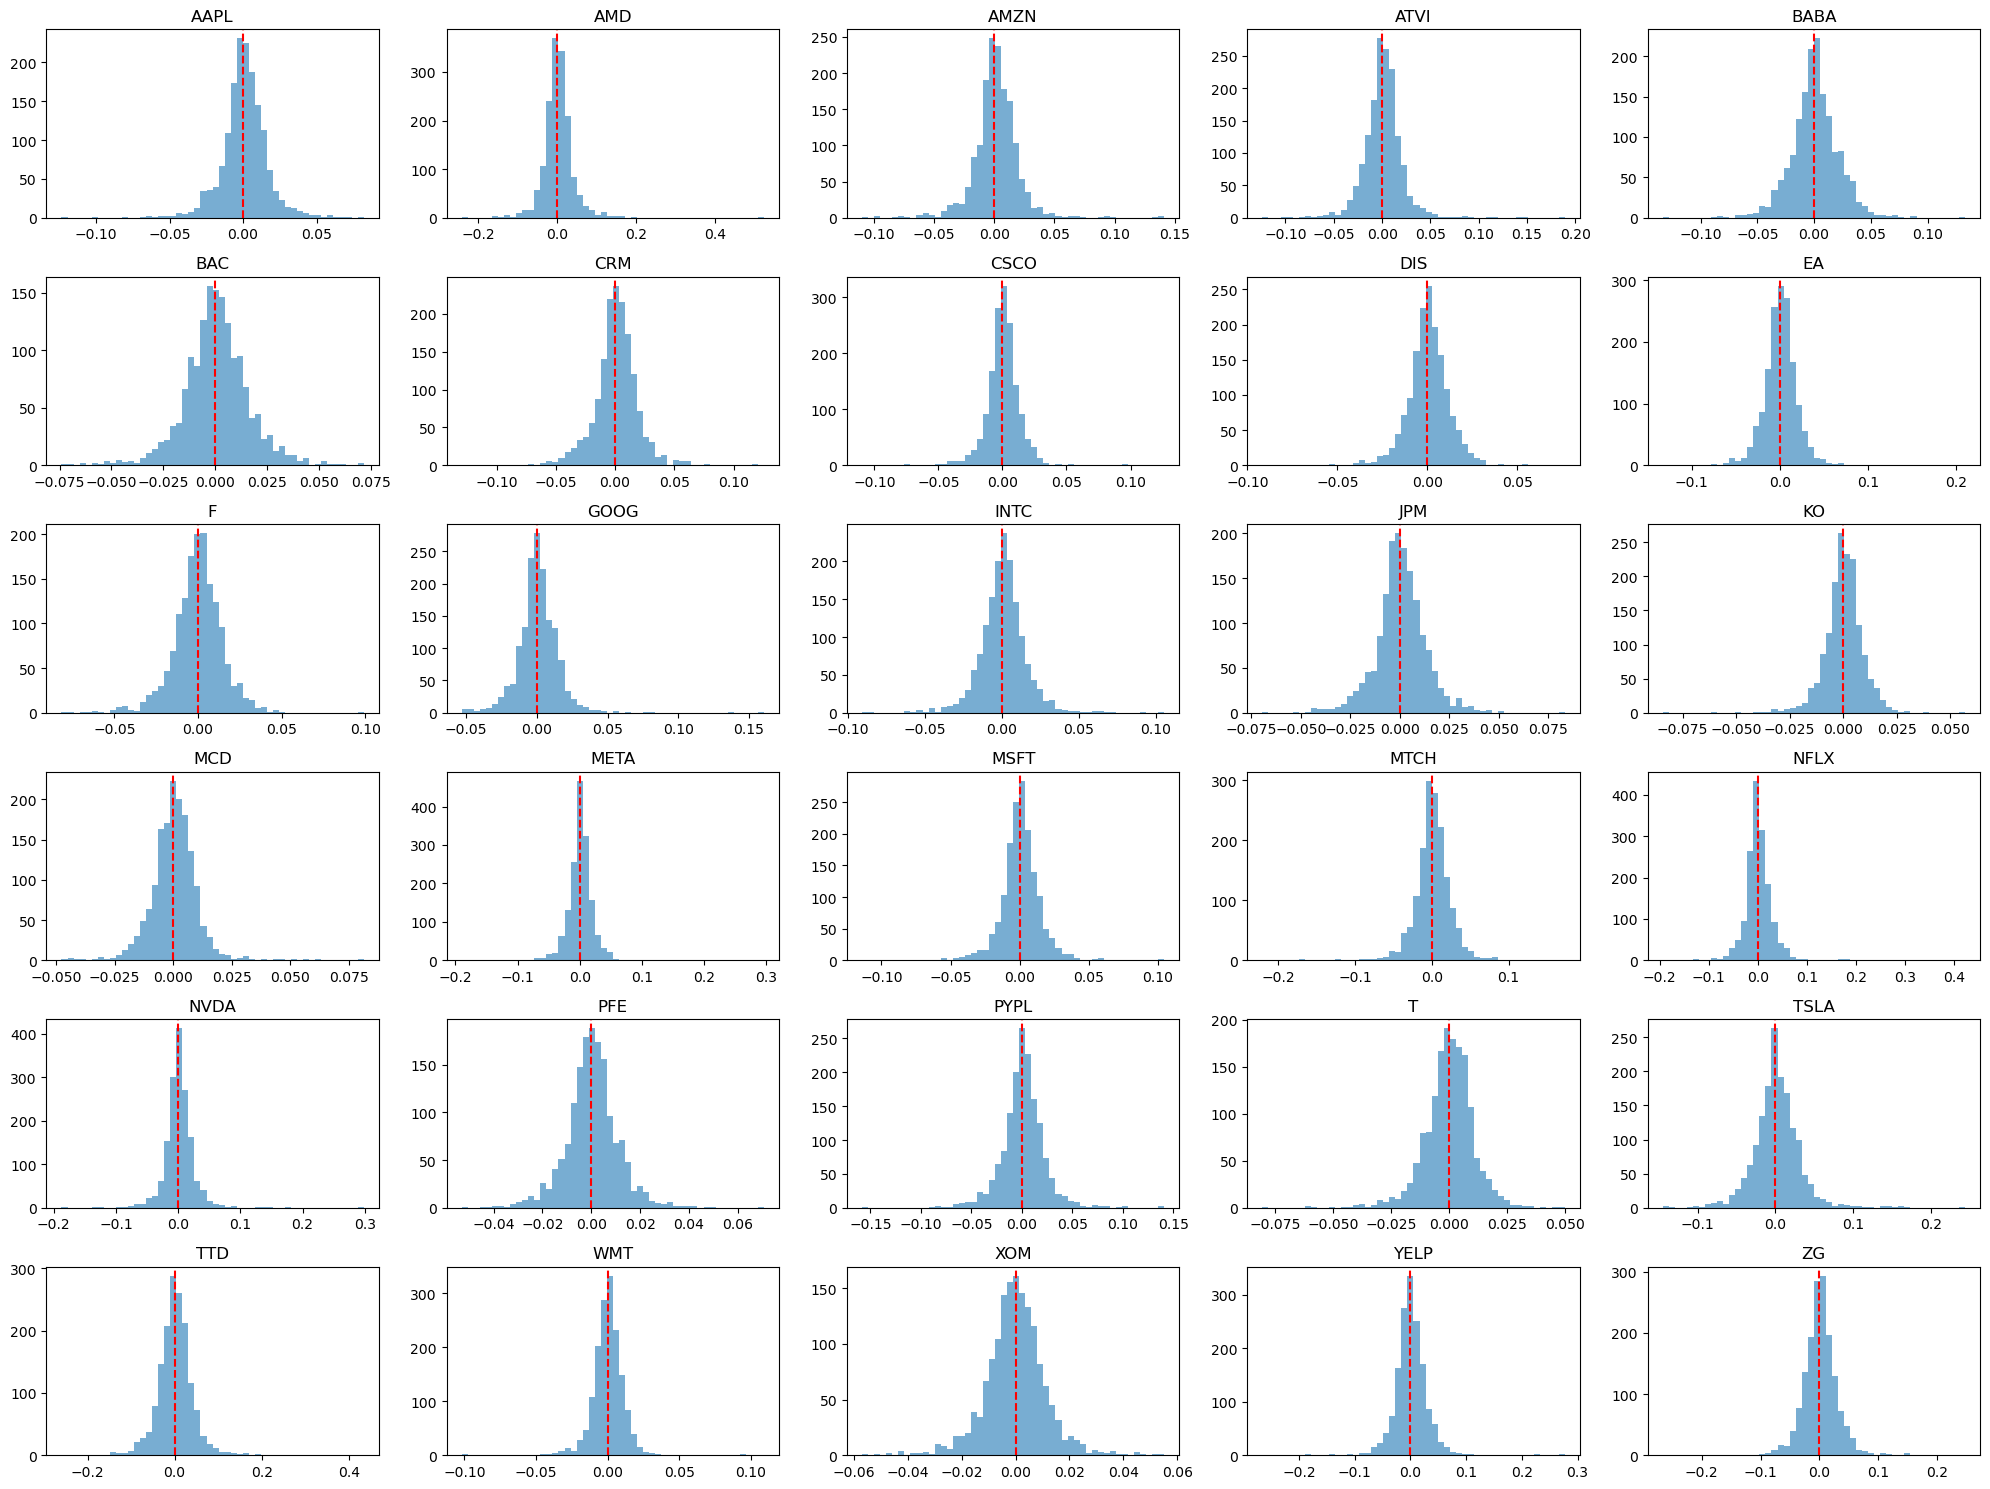

In [7]:
axes = combined_df.hist(figsize=(20, 15), alpha = 0.6, bins = 50, sharex = False, sharey = False)
axes = axes.flatten()
for ax in axes: 
    ax.axvline(0, color = "red", linestyle = "--")
    ax.grid(False)

plt.tight_layout()

## Target Distribution 

In [8]:
# =============================================
# Step 2: Define Target Distribution (e.g., Normal)
# =============================================
target_mean, target_std = 0.01, 0.04  # Adjust as needed
skewness = 3.0 # for normal distribution set = 0
target_returns = skewnorm.rvs(a = skewness, loc = target_mean, scale = target_std, size=(m, 1))  # Shape (m, 1)

cost = 0.0001

## DmNN Model

In [ ]:
model = dmnn.PortfolioNN(input_dim=n_assets, output_dim=n_assets, hidden_layers=3, neurons_per_layer=100,)
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

In [9]:
# run optimisation 
number_of_epochs = 1000
distance = ["l2", "mmd", "wasserstein"]

# return and weight vectors for different distance metrics 
def DmNNAllMetrics(distances, vol_scaling = True, long_short = True):
    
    dmnn_initial_portfolio_returns = {}
    dmnn_final_portfolio_weights = {}
    dmnn_final_portfolio_returns = {}

    dm_lstm_initial_portolfio_returns = {}
    dm_lstm_final_portfolio_returns = {}
    
    for d in distances:
        # train DmNN
        _, dmnn_initial_returns, _, dmnn_final_weights, dmnn_final_returns, _ = dmnn.backprop(
            asset_returns, 
            target_returns, 
            hidden_layers = 3,
            use_vol_scaling = vol_scaling, 
            target_volatility = target_std, 
            distance_metric = d, 
            long_short = long_short
        )
        
        # train DmLSTM
        # Step 2: Train the model using backprop_rnn
        _, dm_lstm_initial_returns, _, _, dm_lstm_final_returns, _, _ = rnn_model.backprop_rnn(
            asset_returns=asset_returns,
            target_returns= target_returns,
            target_volatility= target_std,
            hidden_dim=10,
            num_layers=3,
            use_vol_scaling= vol_scaling,
            long_short=True,
            distance_metric= d,
            n_epochs=100,
            learning_rate=0.01
        )

        # for dmnn
        dmnn_initial_portfolio_returns[d] = dmnn_initial_returns
        dmnn_final_portfolio_returns[d] = dmnn_final_returns
        dmnn_final_portfolio_weights[d] = dmnn_final_weights

        # for dm lstm
        dm_lstm_initial_portolfio_returns[d] = dm_lstm_initial_returns
        dm_lstm_final_portfolio_returns[d] = dm_lstm_final_returns

    return dmnn_initial_portfolio_returns, dmnn_final_portfolio_returns, dmnn_final_portfolio_weights, dm_lstm_initial_portolfio_returns, dm_lstm_final_portfolio_returns

In [10]:
dmnn_initial_returns_VS, dmnn_final_portfolio_returns_VS, dmnn_final_portfolio_weights_VS, \
      dm_lstm_initial_portolfio_returns_VS, dm_lstm_final_portfolio_returns_VS = DmNNAllMetrics(distance, long_short = True)

100%|██████████| 100/100 [00:22<00:00,  4.54it/s]


In [11]:
dmnn_initial_returns_nVS, dmnn_final_portfolio_returns_nVS, dmnn_final_portfolio_weights_nVS, \
    dm_lstm_initial_portolfio_returns_nVS, dm_lstm_final_portfolio_returnsn_nVS = DmNNAllMetrics(distance, vol_scaling = False)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:21<00:00,  4.62it/s]


### get optimised model weights

In [22]:
dmnn_model = dmnn.PortfolioNN(len(tickers), len(tickers))
_, _, _, _, _, dmnn_model_trained = dmnn.backprop(asset_returns, target_returns, target_std, distance_metric='wasserstein', use_vol_scaling=True)
#for name, param in dmnn_model_trained.named_parameters(): 
#    print(param.data)

100%|██████████| 1000/1000 [00:01<00:00, 630.29it/s]


After optimisation fit model. Lag returns so to avoid look ahead bias

In [23]:
asset_returns_unseen_lagged = np.roll(asset_returns_unseen, 1, axis = 0)
out_sample_weights = dmnn_model_trained(torch.FloatTensor(asset_returns_unseen_lagged))

make sure every prediction sums to 1 

In [ ]:
weight_sums = []
for indx in range(len(out_sample_weights)): 
    weight_sum = out_sample_weights[indx].abs().sum()
    weight_sums.append(weight_sum)
weight_sums

now make out of sample prediction

In [24]:
predicted_weights = out_sample_weights.detach().numpy()
dmnn_out_sample_returns = pm.get_returns(predicted_weights, asset_returns_unseen, target_volatility=target_std, window = 50, cost=0.004, use_vol_scaling=False)

In [25]:
pm.calculate_sharpe_ratio(dmnn_out_sample_returns)

np.float64(0.6373778158347755)

## DmLSTM 

In [26]:
# Step 1: Instentiate and Train the model using backprop_rnn
portfolio_original_weights, portfolio_returns_initial, weights, final_weights, portfolio_returns_final_dm_lstm, loss_history, dm_lstm_trained = \
    rnn_model.backprop_rnn(
    asset_returns=asset_returns,
    target_returns= target_returns,
    target_volatility= target_std,
    hidden_dim=100,
    num_layers=2,
    use_vol_scaling=True,
    long_short=True,
    distance_metric='wasserstein',
    n_epochs=100,
    learning_rate=0.001
)

dm_lstm_weights_out_sample = dm_lstm_trained(torch.FloatTensor(np.roll(asset_returns_unseen, 1)))

# Step 2: Compute out-of-sample portfolio returns for validation
dm_lstm_returns = pm.get_returns(dm_lstm_weights_out_sample.detach().numpy(), 
                                asset_returns_unseen, 
                                window = 50, 
                                target_volatility = target_std, 
                                cost = cost)

100%|██████████| 100/100 [00:24<00:00,  4.09it/s]


predict out of sample returns

calculate the out of sample volatility scaled returns 

## Priliminary Model EDA

In [27]:
def gaussian_kde_pdf_plot(data: np.array):
    data = [data if len(data.shape) == 1 else data.flatten()]
    kde_pdf = gaussian_kde(data)
    target_returns_ranked  = np.linspace(np.min(data), np.max(data), 1000)
    target_returns_kde_pdf = kde_pdf.pdf(target_returns_ranked)
    return target_returns_ranked, target_returns_kde_pdf

In [37]:
def plot_return_histograms(dmnn_initial_portfolio_returns, 
                           dmnn_final_portfolio_returns, 
                           dm_lstm_initial_portfolio_returns, 
                           dm_lstm_final_portfolio_returns,
                           target_returns, 
                           distance_metrics, 
                           title
    ):
    
    # Create figure with 2 rows and 3 columns
    fig, axes = plt.subplots(2, 3, figsize=(18, 10), dpi = 300)
    fig.suptitle(title, fontsize=16)
    
    # Flatten axes for easier iteration
    axes = axes.flatten()
    
    # Plot histograms for each distance metric
    for i, metric in enumerate(distance_metrics):
        # Get initial and final returns for current metric
        dmnn_initial_returns = dmnn_initial_portfolio_returns[metric]
        dmnn_final_returns = dmnn_final_portfolio_returns[metric]

        dm_lstm_initial_returns = dm_lstm_initial_portfolio_returns[metric]
        dm_lstm_final_returns = dm_lstm_final_portfolio_returns[metric]

        # Calculate positions for current metric's plots
        initial_ax_pos = i
        final_ax_pos = i + 3
        
        # Plot initial returns vs target returns
        axes[initial_ax_pos].hist(target_returns, bins=50, alpha=0.7, color = "blue", label='Target Denisty', edgecolor = 'none', density = True)
        axes[initial_ax_pos].hist(dmnn_initial_returns, bins=50, alpha=0.7, color = "orange", label='DmNN Initial Portfolio Return Density', edgecolor = 'none', density = True)
        axes[initial_ax_pos].hist(dm_lstm_initial_returns, bins=50, alpha=0.7, color = "red", label='DmLSTM Initial Portfolio Return Denisty', edgecolor = 'none', density = True)

        target_returns_ranked_I, target_returns_kde_denisties_I = gaussian_kde_pdf_plot(target_returns)
        axes[initial_ax_pos].plot(target_returns_ranked_I, target_returns_kde_denisties_I, linestyle = "-", color = "blue")        
        
        dmnn_target_returns_ranked_T, dmnn_target_returns_kde_denisties_T = gaussian_kde_pdf_plot(dmnn_initial_returns)
        axes[initial_ax_pos].plot(dmnn_target_returns_ranked_T, dmnn_target_returns_kde_denisties_T, linestyle = "-", color = "orange")

        dm_lstm_target_returns_ranked_T, dm_lstm_target_returns_kde_denisties_T = gaussian_kde_pdf_plot(dm_lstm_initial_returns)
        axes[initial_ax_pos].plot(dm_lstm_target_returns_ranked_T, dm_lstm_target_returns_kde_denisties_T, linestyle = "-", color = "red")

        axes[initial_ax_pos].grid(False)
        axes[initial_ax_pos].set_title(f'Pre-Trained Model vs Target Output ({metric})')
        axes[initial_ax_pos].legend()
        
        # Plot final returns vs target returns
        axes[final_ax_pos].hist(target_returns, bins=50, alpha=0.7, color = "blue", label='Target Return Density', edgecolor = 'none', density = True)
        axes[final_ax_pos].hist(dmnn_final_returns, bins=50, alpha=0.7, color = "orange", label='DmNN Trained Portfolio Return Denisty', edgecolor = 'none', density = True)
        axes[final_ax_pos].hist(dm_lstm_final_returns, bins=50, alpha=0.7, color = "red", label='DmLSTM Trained Portfolio Return Denisty', edgecolor = 'none', density = True)

        dmnn_final_returns_ranked, dmnn_final_returns_kde_densities  = gaussian_kde_pdf_plot(dmnn_final_returns)
        dm_lstm_final_returns_ranked, dm_lstm_final_returns_kde_densities  = gaussian_kde_pdf_plot(dm_lstm_final_returns)

        axes[final_ax_pos].plot(dmnn_final_returns_ranked, dmnn_final_returns_kde_densities, linestyle = "-", color = "orange")   

        axes[final_ax_pos].plot(target_returns_ranked_I, target_returns_kde_denisties_I, linestyle = "-", color = "blue")   

        axes[final_ax_pos].plot(dm_lstm_final_returns_ranked, dm_lstm_final_returns_kde_densities, linestyle = "-", color = "red")        

        axes[final_ax_pos].grid(False)
        axes[final_ax_pos].set_title(f'Trained Model vs Target Ouput ({metric})')
        axes[final_ax_pos].legend()
    
    plt.tight_layout()
    plt.show()

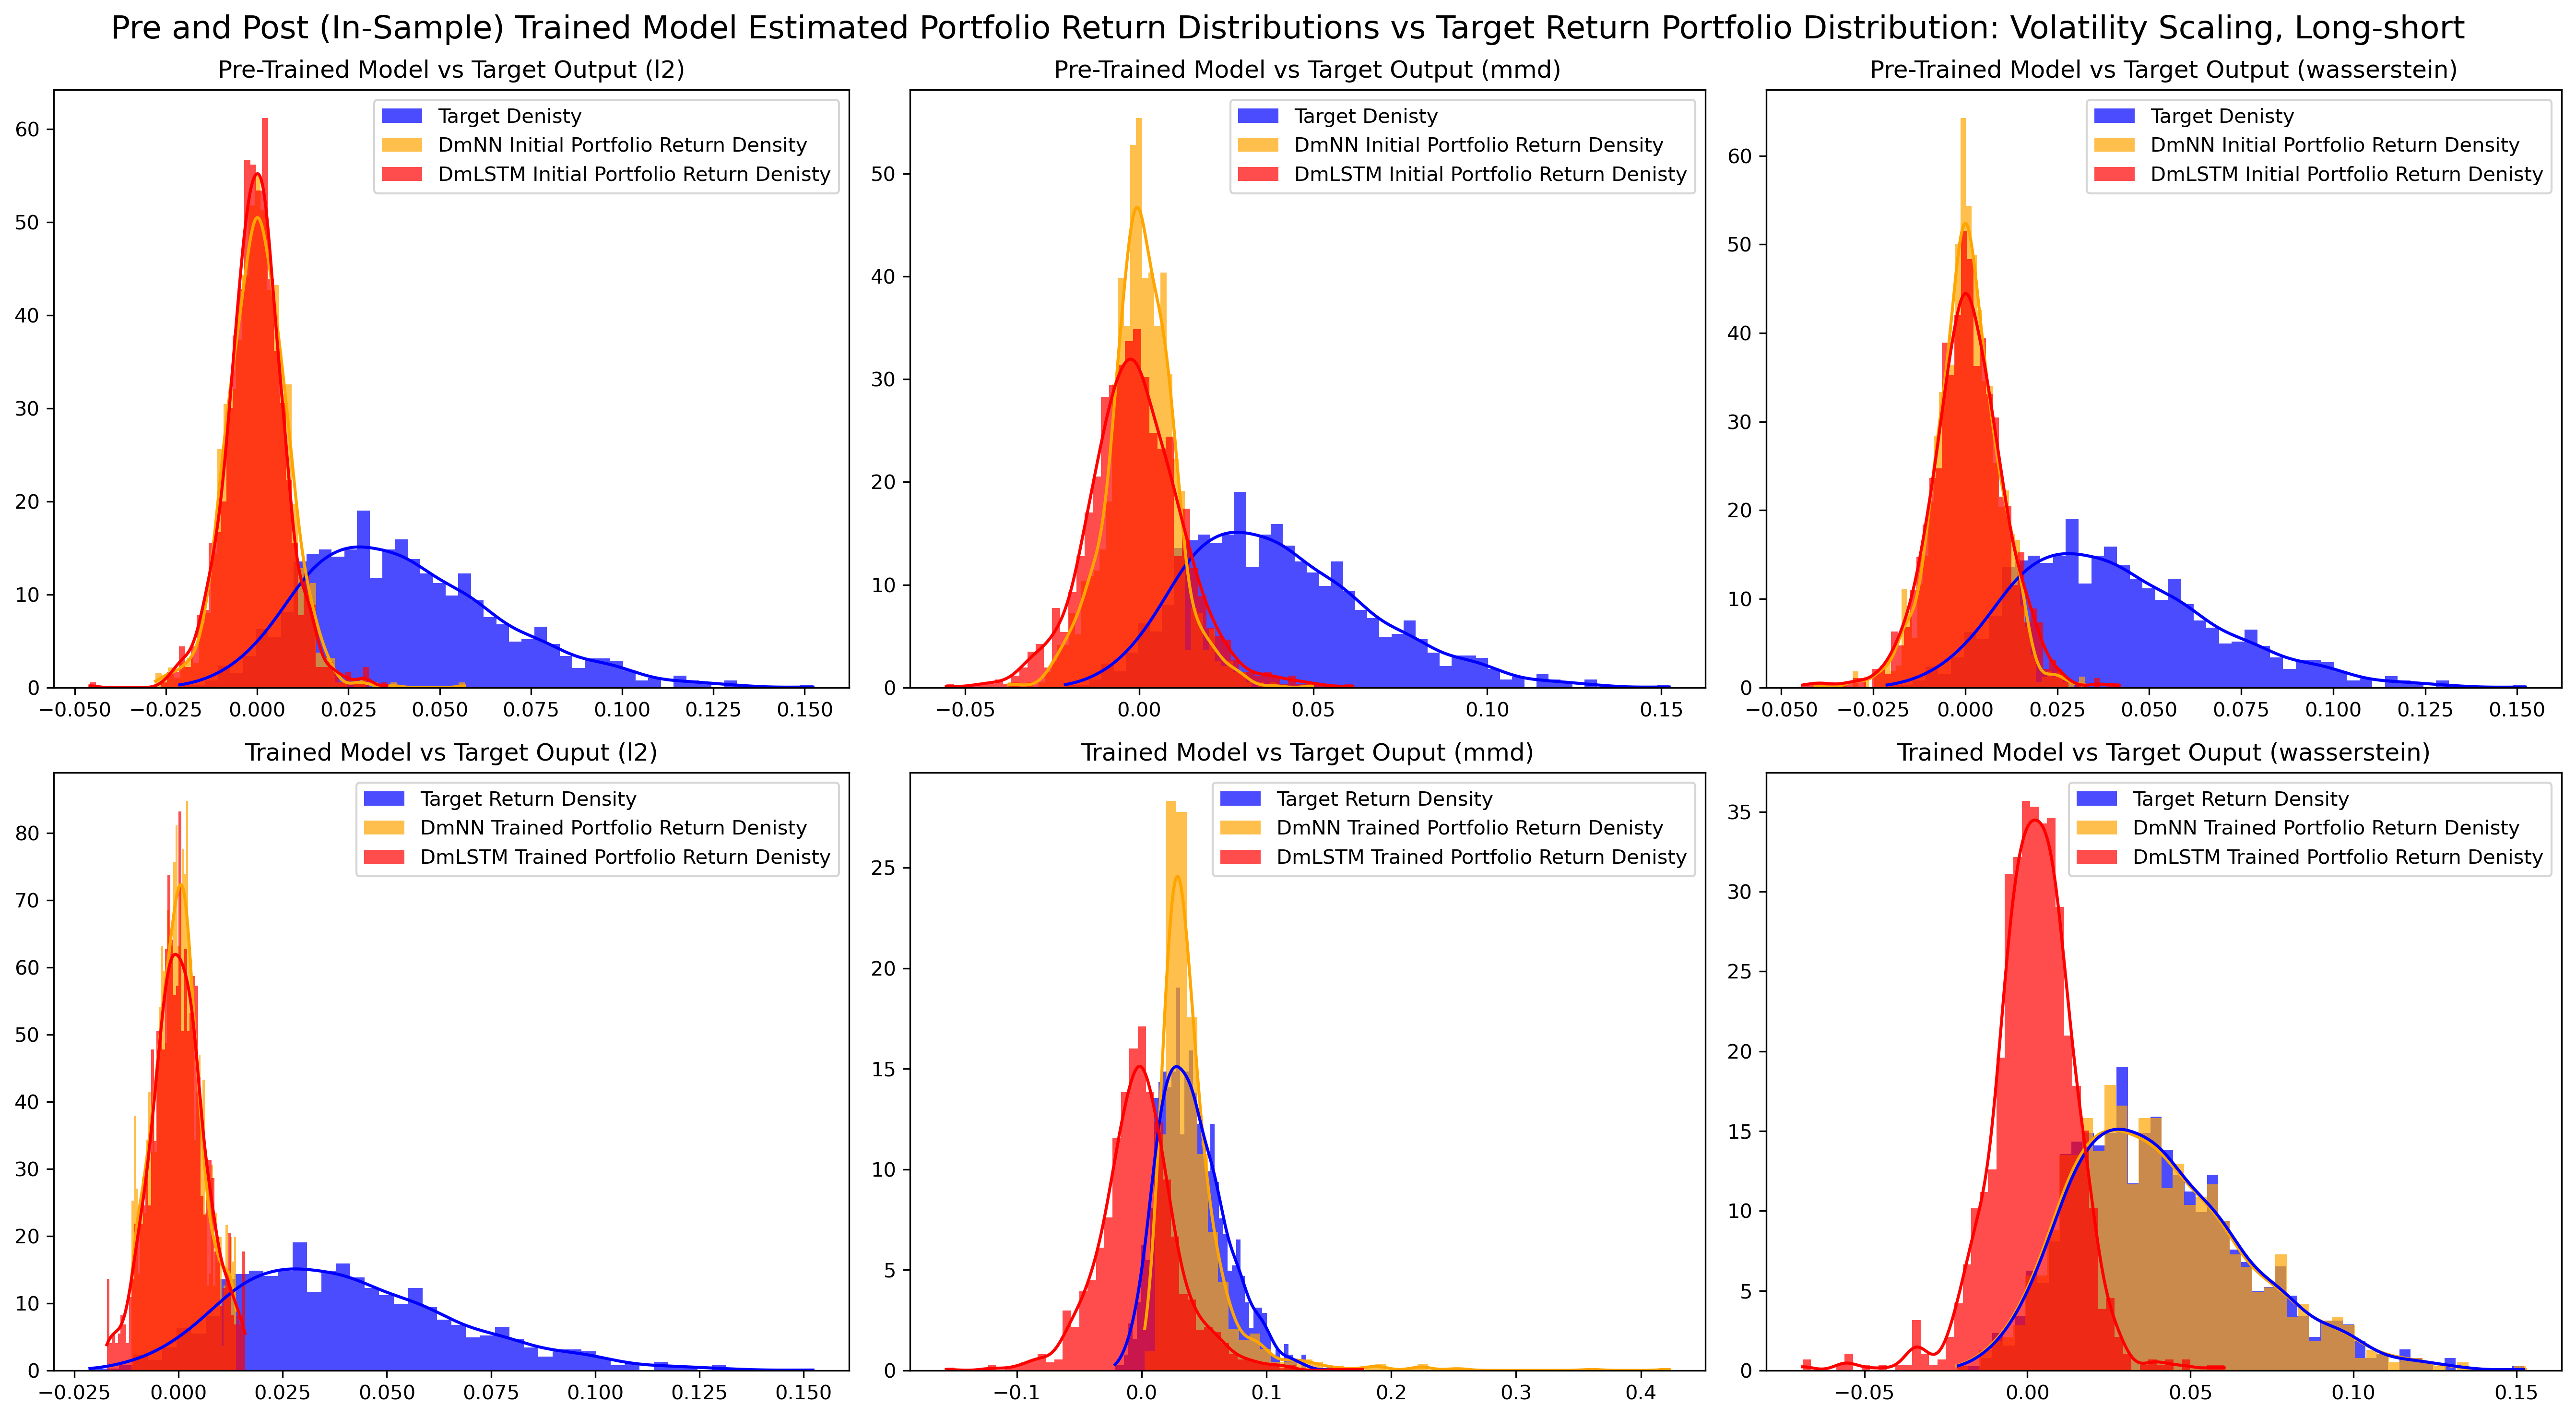

In [38]:
plot_return_histograms(dmnn_initial_returns_VS,
                       dmnn_final_portfolio_returns_VS, 
                       dm_lstm_initial_portolfio_returns_VS,
                       dm_lstm_final_portfolio_returns_VS,
                       target_returns, 
                       distance, 
                       title = "Pre and Post (In-Sample) Trained Model Estimated Portfolio Return Distributions vs Target Return Portfolio Distribution: Volatility Scaling, Long-short")

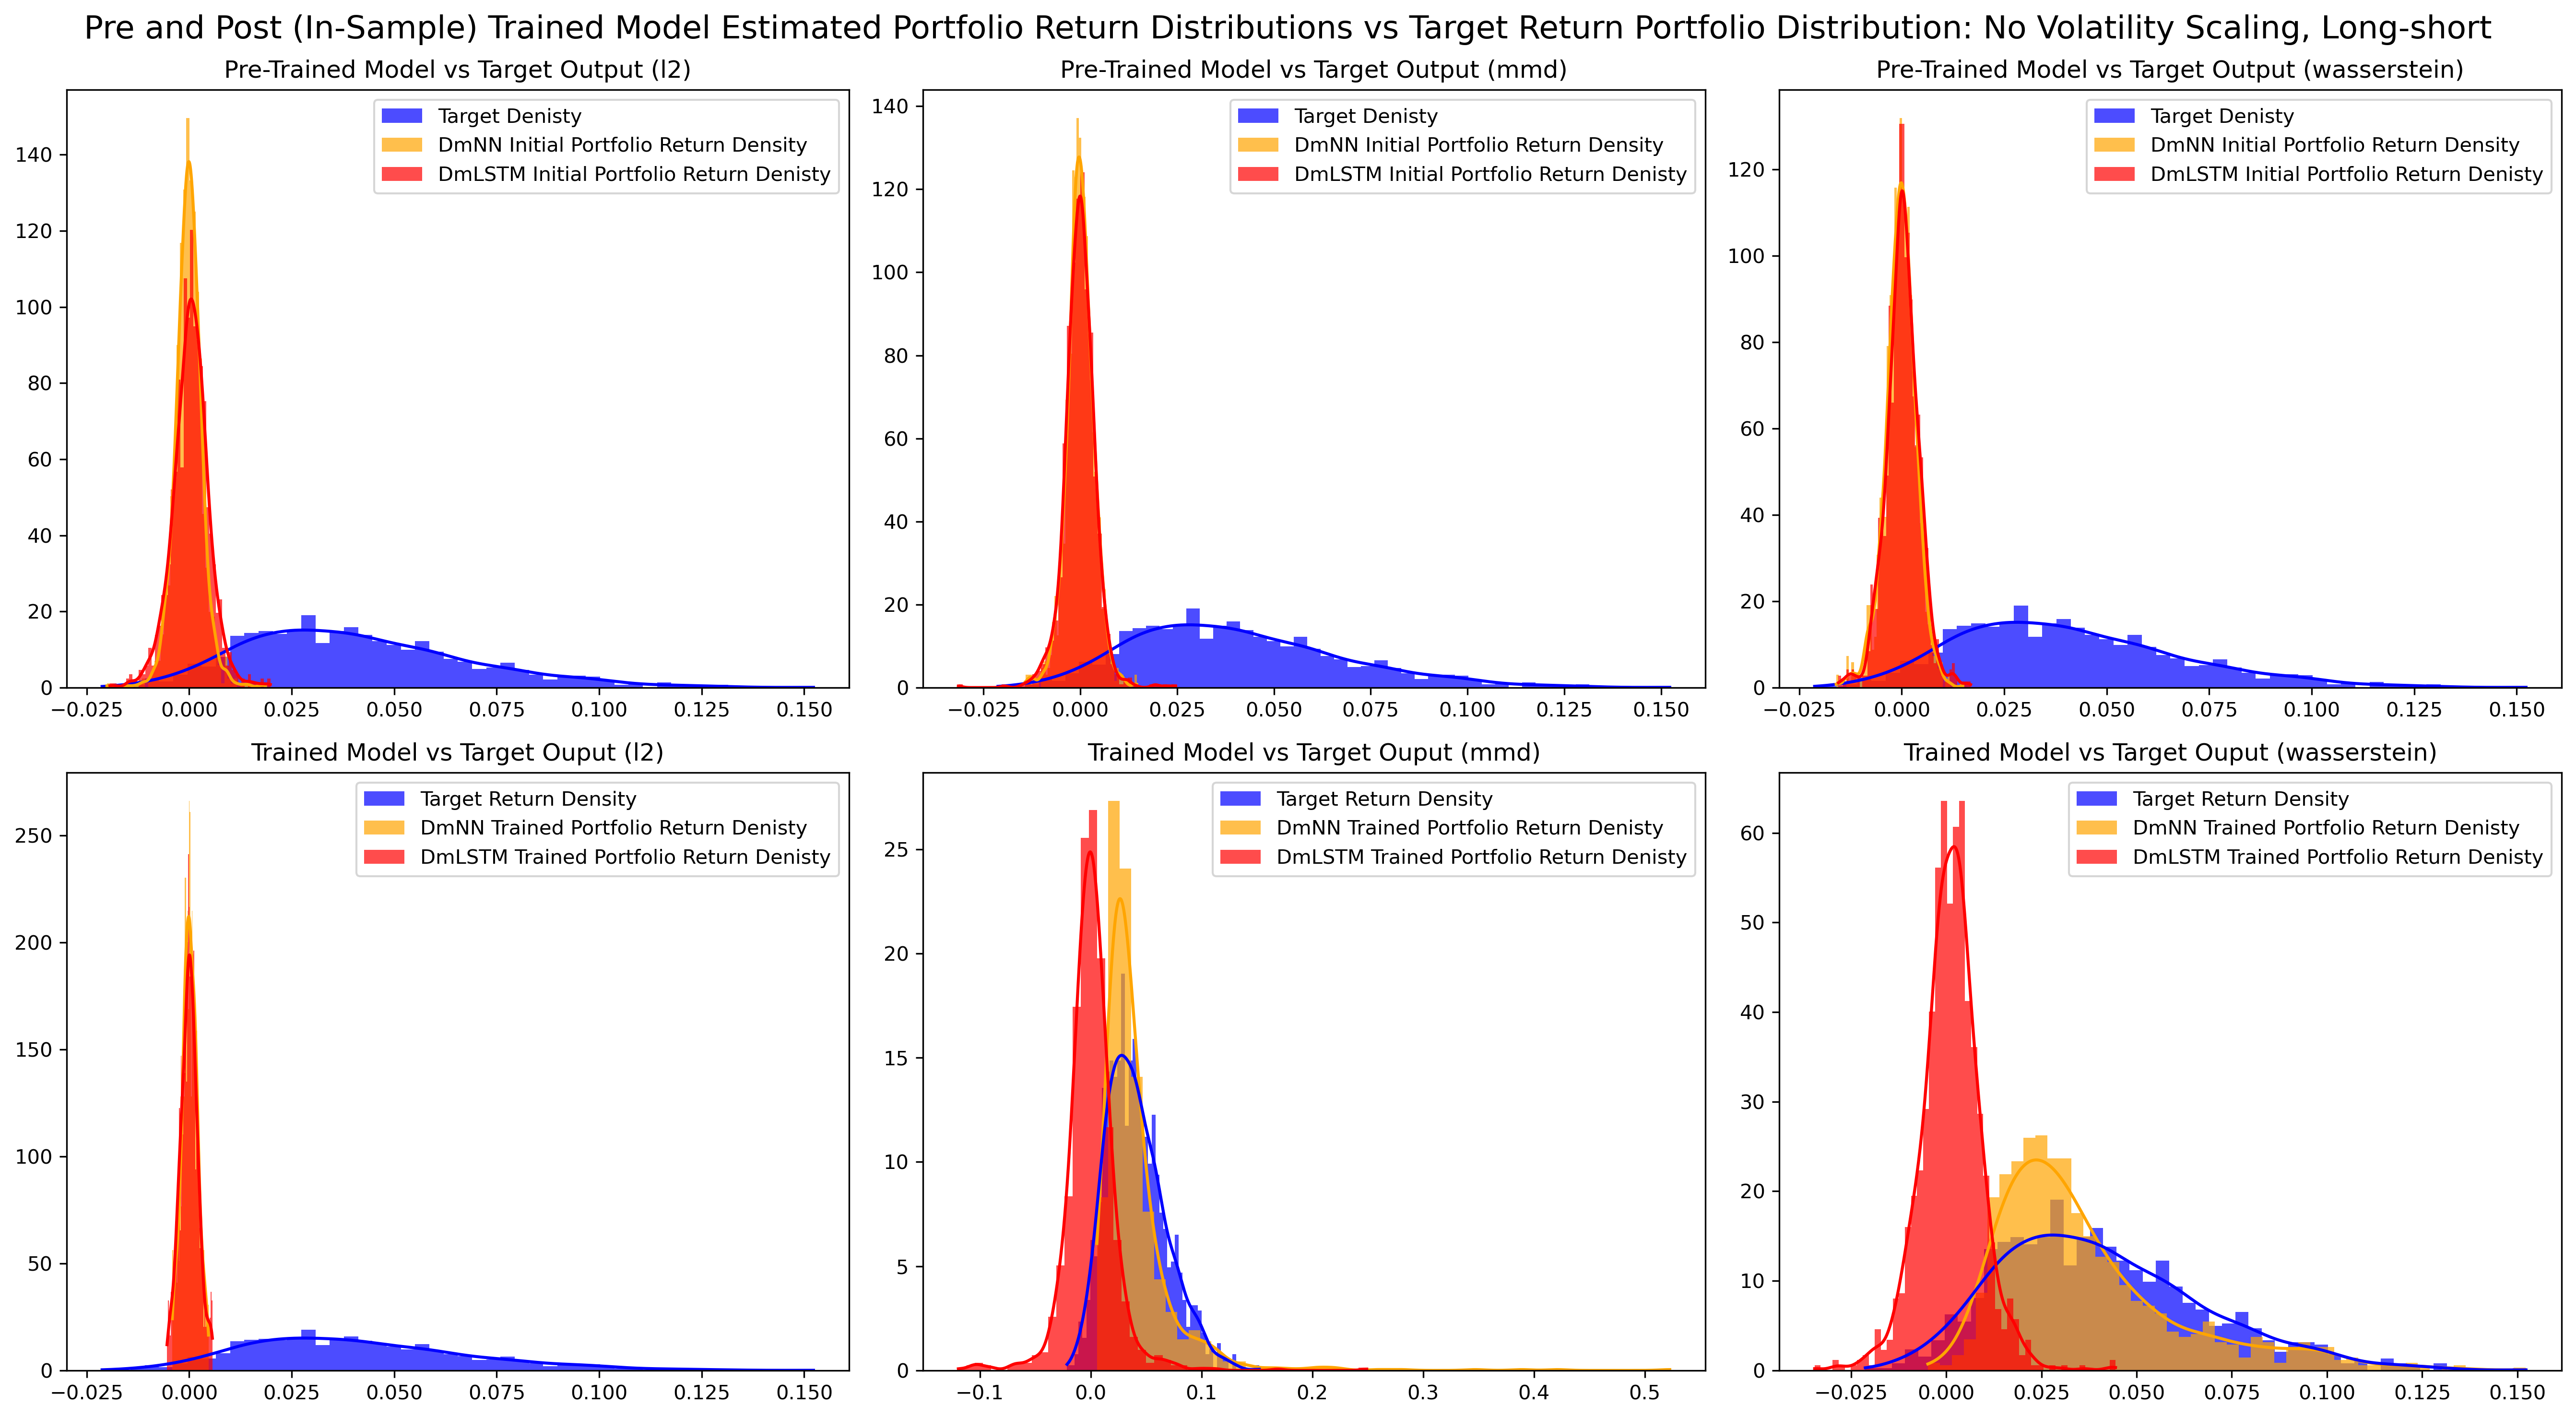

In [39]:
plot_return_histograms(dmnn_initial_returns_nVS,
                       dmnn_final_portfolio_returns_nVS, 
                       dm_lstm_initial_portolfio_returns_nVS,
                       dm_lstm_final_portfolio_returnsn_nVS,
                       target_returns, 
                       distance, 
                       title = "Pre and Post (In-Sample) Trained Model Estimated Portfolio Return Distributions vs Target Return Portfolio Distribution: No Volatility Scaling, Long-short")

/var/folders/mg/82w1c_cd6r3cv72tkghtghkm0000gn/T/ipykernel_13657/3047173683.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('coolwarm')


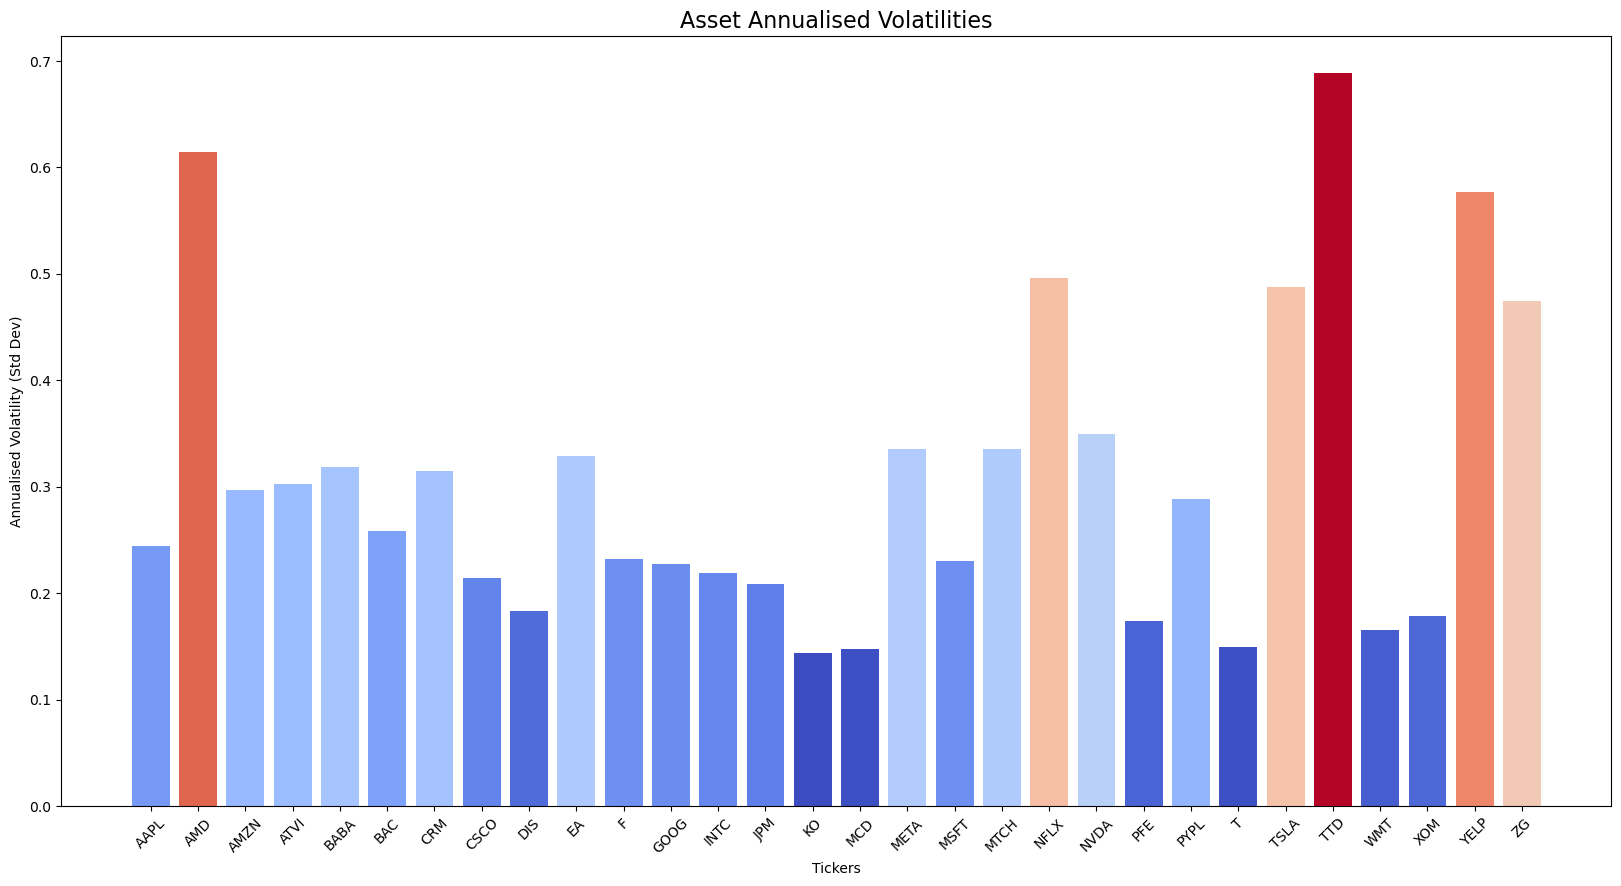

In [ ]:
# Assuming 'tickers' and 'asset_returns' are already defined in your code.
# Compute volatilities (standard deviations)
vols = np.std(asset_returns, axis=0) * 252**0.5

# Normalize volatilities to [0, 1] for colormap scaling
norm = mcolors.Normalize(vmin=np.min(vols), vmax=np.max(vols))

# Choose a colormap (e.g., 'viridis' for green-to-yellow gradient; alternatives: 'coolwarm', 'RdYlGn', 'plasma')
cmap = get_cmap('coolwarm')

# Generate colors based on normalized volatilities
colors = [cmap(norm(vol)) for vol in vols]

# Plot with gradient colors
plt.figure(figsize=(20, 10))
plt.grid(False)
plt.bar(x=tickers, height=vols, color=colors)
plt.title("Asset Annualised Volatilities", fontsize = 16)
plt.xlabel("Tickers")  # Optional: Add x-label for clarity
plt.ylabel("Annualised Volatility (Std Dev)")  # Optional: Add y-label for clarity
plt.xticks(rotation=45)  # Optional: Rotate x-ticks if tickers are long/many
plt.show()

In [89]:
# calculate the EMA's of volatility for each window size  
std_emas = {}
step_size = 20
for window in range(10, 50+step_size, step_size): 
    std_ema = dls.std_ema(asset_returns_unseen, window = window)
    volatility_scaling = target_std / std_ema 
    std_emas[f'VS: Window={window}'] = volatility_scaling

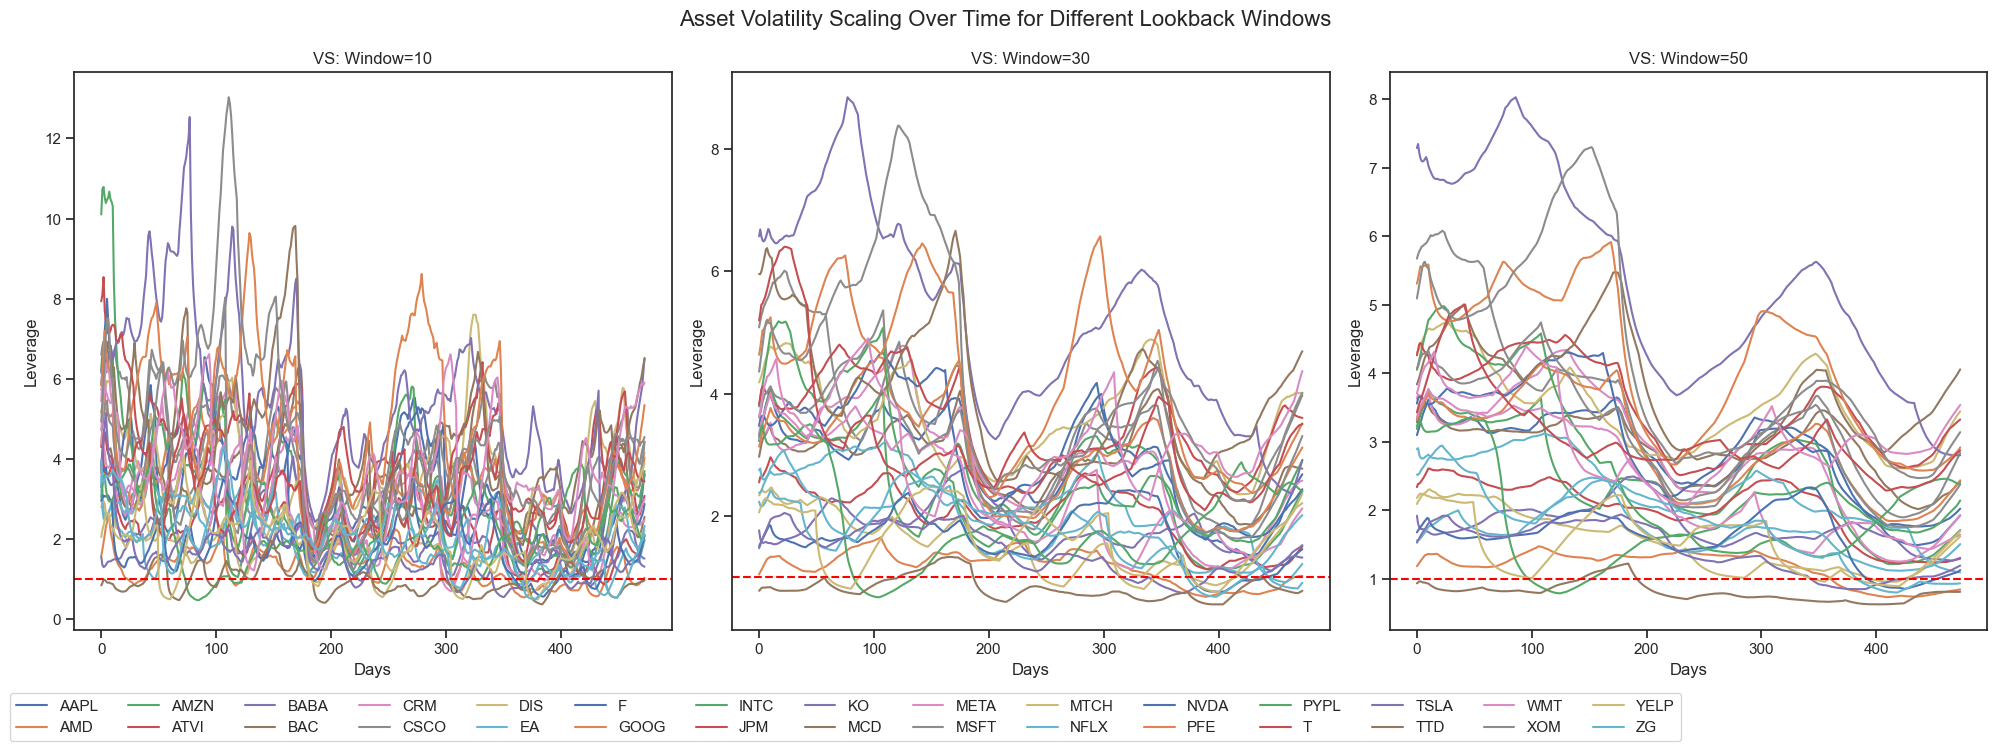

In [90]:
# plot volatility scales for different STD EMA windows 
fig, ax = plt.subplots(nrows = 1, ncols = len(std_emas.keys()), figsize = (20, 7))
fig.suptitle('Asset Volatility Scaling Over Time for Different Lookback Windows', fontsize = 16)
for idx, key in enumerate(std_emas.keys()):
    ax[idx].plot(std_emas[key], label = tickers)
    ax[idx].set_title(f'{key}')
    ax[idx].axhline(1, linestyle = '--', color = 'red')
    ax[idx].set_ylabel('Leverage')
    ax[idx].set_xlabel('Days')
plt.tight_layout()
plt.legend(bbox_to_anchor=(0.5, -0.1), ncol=len(tickers)/2)

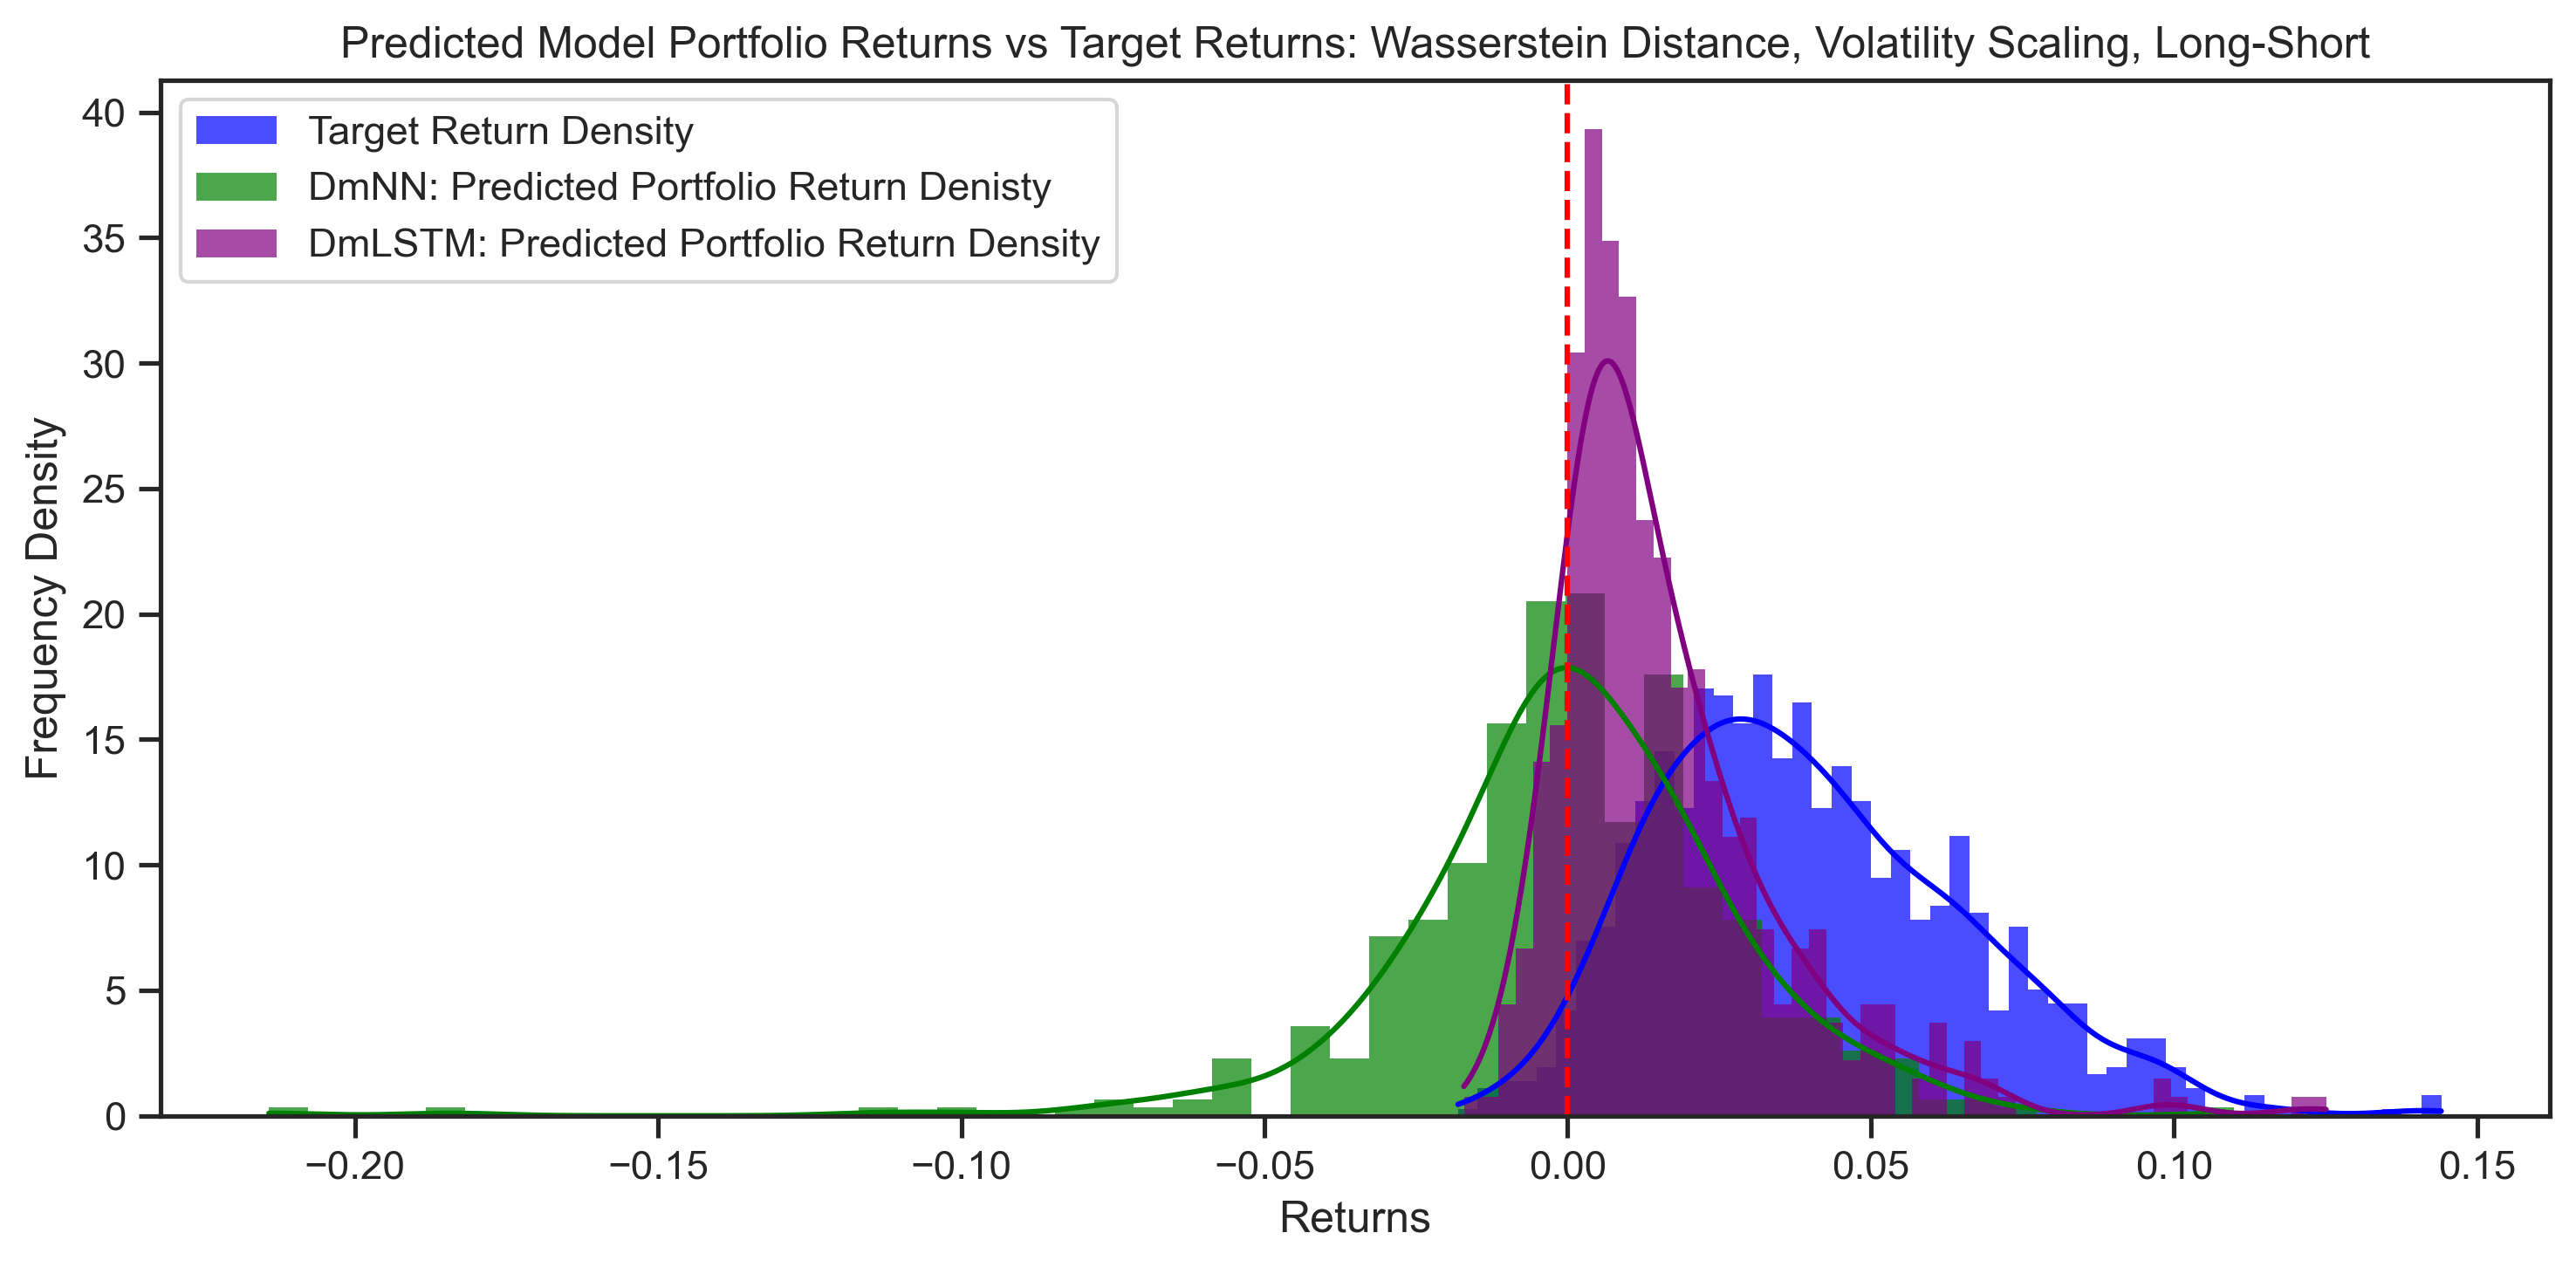

In [88]:
d_type = "wasserstein"
sorted_out_of_sample_returns, out_of_sample_returns_kde_denisties = gaussian_kde_pdf_plot(dmnn_out_sample_returns)
target_returns_ranked, target_returns_kde_denisties = gaussian_kde_pdf_plot(target_returns)
dm_lstm_out_sample_retunrs_ranked, dm_lstm_out_sample_returns_kde_denities = gaussian_kde_pdf_plot(dm_lstm_returns)

plt.figure(figsize = (10, 5), dpi = 300)

plt.hist(target_returns, bins = 50, edgecolor = "none", label = "Target Return Density", color = 'blue', alpha = 0.7, density = True)
plt.plot(target_returns_ranked, target_returns_kde_denisties, linestyle = "-", color = "blue") 

plt.hist(dmnn_out_sample_returns, bins = 50, edgecolor = "none", label = "DmNN: Predicted Portfolio Return Denisty", color = 'green', alpha = 0.7, density = True)
plt.plot(sorted_out_of_sample_returns, out_of_sample_returns_kde_denisties, linestyle = "-", color = "green")  

plt.hist(dm_lstm_returns, bins = 50, edgecolor = "none", label = "DmLSTM: Predicted Portfolio Return Density", color = 'purple', alpha = 0.7, density = True)
plt.plot(dm_lstm_out_sample_retunrs_ranked, dm_lstm_out_sample_returns_kde_denities, linestyle = "-", color = "purple") 

plt.title("Predicted Model Portfolio Returns vs Target Returns: Wasserstein Distance, Volatility Scaling, Long-Short")
plt.axvline(0, linestyle = '--', color = 'red')
plt.xlabel("Returns")
plt.ylabel("Frequency Density")
plt.tight_layout()
plt.grid(False)
plt.legend()

## MVO Efficient Frontier, Maximal Sharpe Ratio and CML

/var/folders/mg/82w1c_cd6r3cv72tkghtghkm0000gn/T/ipykernel_5986/1793989969.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(tickers_max_sharpe, rotation=90, ha="center")


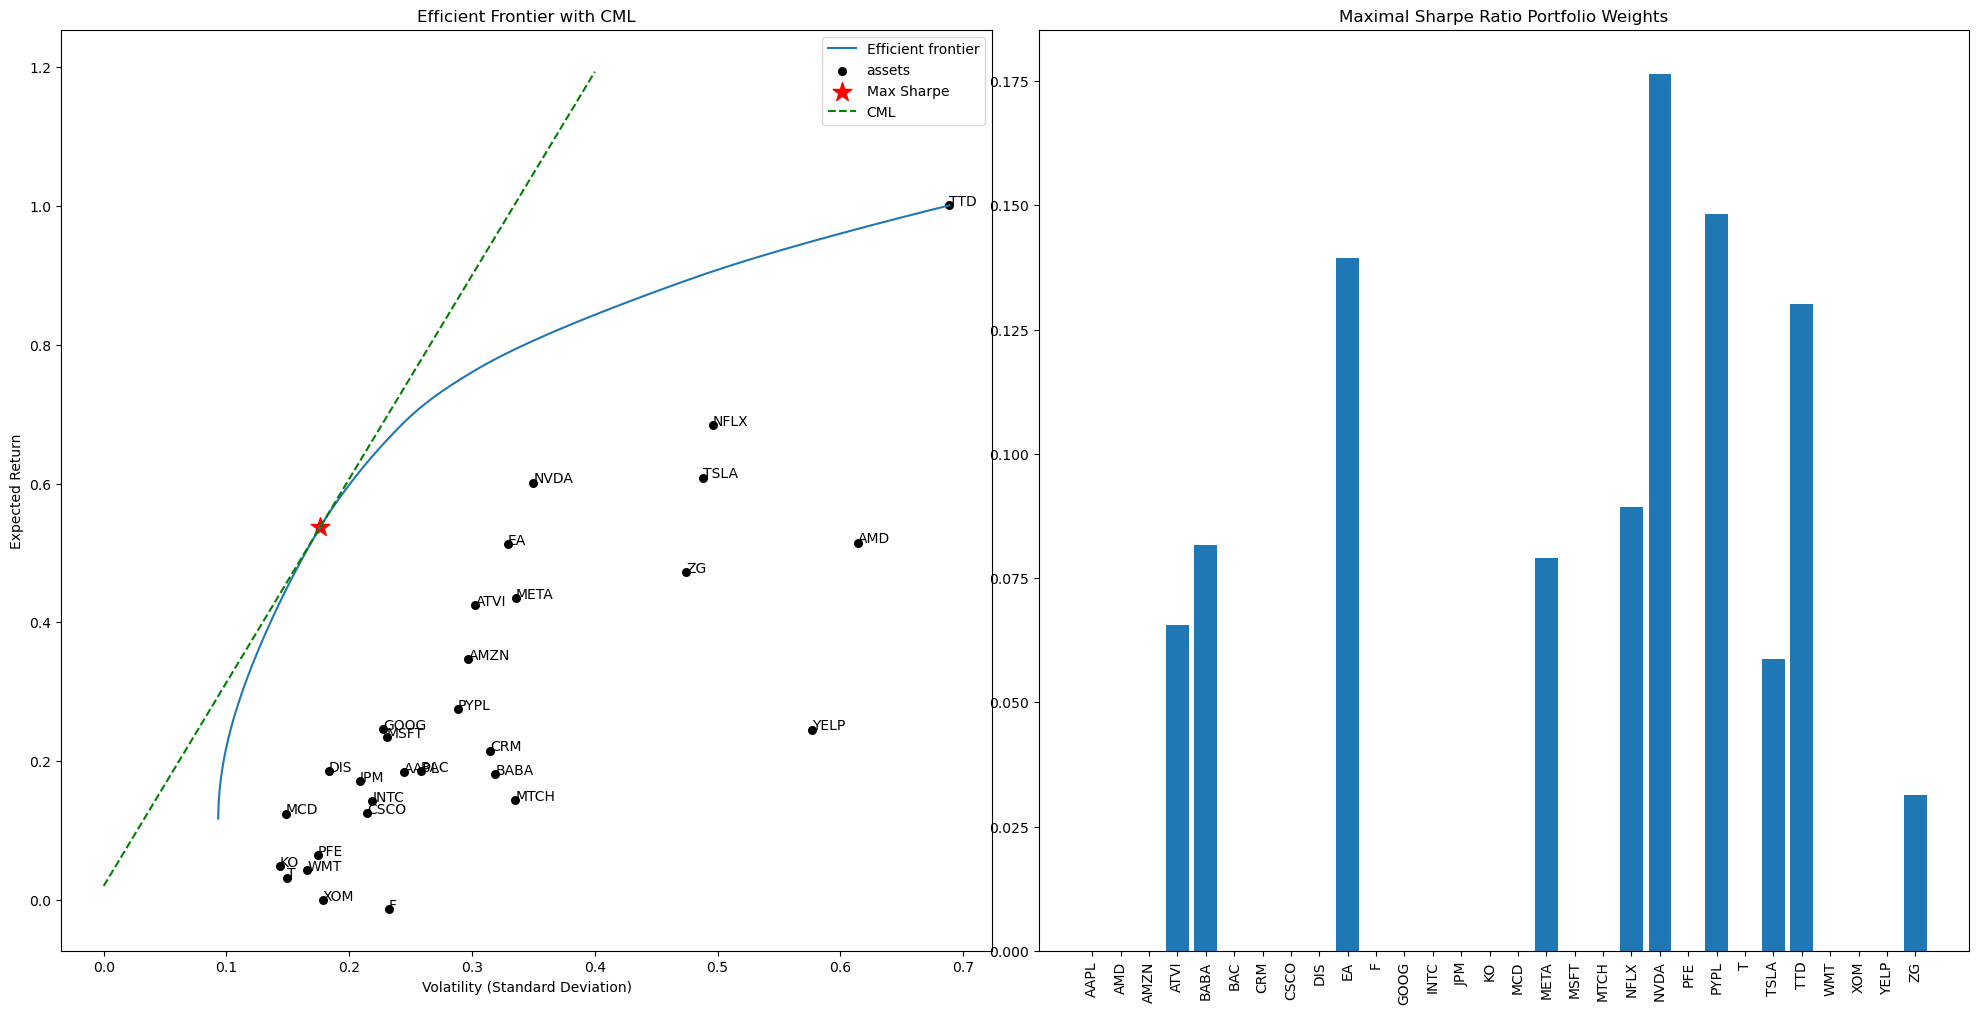

<Figure size 640x480 with 0 Axes>

In [37]:
def plot_frontier_and_cml(return_data, risk_free_rate=0.0, ax = ax):
    weights, mu, S, (ret, vol, sharpe) = mvo.calculate_mvo(return_data, risk_free_rate)

    # Create new EF instance for plotting frontier
    ef_frontier = EfficientFrontier(mu, S, weight_bounds=(0, 1))

    plotting.plot_efficient_frontier(ef_frontier, ax=ax, show_assets=True, show_tickers=True)

    # Plot the max Sharpe portfolio
    ax.scatter(vol, ret, marker="*", s=200, c="r", label="Max Sharpe")

    # Plot the Capital Market Line (CML)
    x = np.linspace(0, max(vol*1.5, 0.4), 100)
    y = risk_free_rate + sharpe * x
    ax.plot(x, y, linestyle="--", color="green", label="CML")

    ax.set_title("Efficient Frontier with CML")
    ax.set_xlabel("Volatility (Standard Deviation)")
    ax.set_ylabel("Expected Return")
    ax.legend()
    ax.grid(False)

    return weights, (ret, vol, sharpe), S


# Example usage (return_data is a DataFrame of daily returns):
fig, ax = plt.subplots(1, 2, figsize = (20, 10))
weights, perf, cov_matrix = plot_frontier_and_cml(pd.DataFrame(asset_returns, columns = tickers), risk_free_rate = 0.02, ax = ax[0])
weights = dict(weights)
tickers_max_sharpe = list(weights.keys())
weights_max_sharpe = list(weights.values())
ax[1].bar(tickers_max_sharpe, height = weights_max_sharpe)
ax[1].set_xticklabels(tickers_max_sharpe, rotation=90, ha="center")
ax[1].grid(False)
ax[1].set_title("Maximal Sharpe Ratio Portfolio Weights")
plt.show()
plt.tight_layout()

## Bootstrap Hypothesis Test 

In [42]:
def bootstrap_hypothesis_test(sample_P: np.ndarray, 
                              sample_Q: np.ndarray,
                              metric = "wasserstein", 
                              n_bootstraps: int = 999,
                              random_seed: int = 42) -> tuple:
    np.random.seed(random_seed)

    observed_stat = None 
    
    # Pool the samples under the null hypothesis (H0: P = Q)
    pooled = np.concatenate([sample_P, sample_Q])
    n_P = len(sample_P)
    
    # Observed test statistic
    if metric == "mmd":
        observed_stat = dmnn.mmd_unbiased(sample_P, sample_Q)
    elif metric == "l2":        
        observed_stat = dmnn.l2_loss(sample_P, sample_Q)
    elif metric == "wasserstein":
        observed_stat = dmnn.wasserstein_distance(sample_P, sample_Q)
    
    # Bootstrap distribution of the test statistic under H0
    bootstrap_stats = np.zeros(n_bootstraps)
    for i in range(n_bootstraps):
        # Resample from the pooled data with replacement, distributions under H0 are assumed to be equal 
        resampled_P = resample(pooled, n_samples=n_P, replace=True)
        resampled_Q = resample(pooled, n_samples=len(sample_Q), replace=True)
        
        # Compute the metric on resampled data
        if metric == "mmd":
            bootstrap_stats[i] = dmnn.mmd_unbiased(resampled_P, resampled_Q)
        elif metric == "l2":        
            bootstrap_stats[i] = dmnn.l2_loss(resampled_P, resampled_Q)
        elif metric == "wasserstein":
            bootstrap_stats[i] = dmnn.wasserstein_distance(resampled_P, resampled_Q)

    # Calculate p-value (left tailed test)
    p_value = np.mean(np.asarray(bootstrap_stats) < np.asarray(observed_stat)) 
    
    return p_value, observed_stat, bootstrap_stats

# Model Approach Validation

In [43]:
# Helper function to compute out-of-sample returns for non-DLS models
def compute_out_sample_returns(model, asset_returns, model_inputs, target_volatility, cost_per_trade, window=100, vol_scaling = True):
    """
    Abstracted function to predict weights and compute out-of-sample returns for models expecting 2D input.
    """
    out_sample_weights = model(torch.FloatTensor(model_inputs))
    predicted_weights = out_sample_weights.detach().numpy()
    out_sample_returns = pm.get_returns(
        predicted_weights, 
        asset_returns,
        window=window, 
        target_volatility=target_volatility,
        cost=cost_per_trade,
        use_vol_scaling = vol_scaling
    )
    return out_sample_returns

# Helper function to compute metrics
def compute_metrics(out_sample_returns):
    """
    Abstracted function to compute Sharpe, Sortino, VaR, and CVaR.
    These metrics are grounded in statistical theory: Sharpe ratio measures excess return per unit of volatility (standard deviation),
    Sortino focuses on downside deviation, VaR is a quantile-based risk measure, and CVaR is the expected loss beyond VaR.
    """
    sharpe = pm.calculate_sharpe_ratio(out_sample_returns, risk_free_rate=0)
    sortino = pm.calculate_sortino_ratio(out_sample_returns)
    var = pm.VaR(out_sample_returns)
    cvar = pm.CVaR(out_sample_returns)
    return sharpe, sortino, var, cvar

def validate_model(
    tickers,
    train_asset_returns, 
    test_asset_returns, 
    target_returns,
    asset_prices,  # Used for DLS training and prediction
    asset_prices_unseen, 
    target_volatility, 
    hidden_layers=3, 
    neurons_per_layer=100,    
    vol_scaling=True, 
    long_short=True, 
    window = 100, 
    cost_per_trade=0.0001,
    num_tickers_to_use=None, 
    num_assets_in_combo=5,  # this is r in nCr
    distance_metric="wasserstein",
    use_random_market_cap=True, 
    number_of_epochs_dmnn=1000,
    number_of_epochs_dmlstm=100,
    number_of_epochs_dls=100,  
    n_bootstraps=999,
    random_seed=42,
    lookback=50  # Added parameter for DLS sequence length, default matching DLS_model.py
):
    # Limit tickers if specified
    if num_tickers_to_use is not None:
        tickers = tickers[:num_tickers_to_use]
        train_asset_returns = train_asset_returns[:, :num_tickers_to_use]
        train_asset_prices = asset_prices[:, :num_tickers_to_use]
        test_asset_returns = test_asset_returns[:, :num_tickers_to_use]
        test_asset_prices = asset_prices_unseen[:, :num_tickers_to_use]

    # Generate combinations
    combos = list(combinations(tickers, num_assets_in_combo))

    # Initialize metric lists 
    metrics = {
        'DmNN Sharpes': [], 'DmNN Sortinos': [], 'VaR Model': [], 'CVaR Model': [],
        'DmLSTM Sharpes': [], 'DmLSTM Sortinos': [], 'VaR DmLSTM': [], 'CVaR DmLSTM': [],
        'MVO Sharpes': [], 'MVO Sortinos': [], 'VaR MVO': [], 'CVaR MVO': [],
        'MVO+BL Sharpes': [], 'MVO+BL Sortinos': [], 'VaR MVO+BL': [], 'CVaR MVO+BL': [],
        'DLS Sharpes': [], 'DLS Sortinos': [], 'VaR DLS': [], 'CVaR DLS': [],
        'p-values': []  # Only for DmNN
    }

    for combo in combos:
        # Subset data for combo
        data_train = pd.DataFrame(train_asset_returns, columns=tickers)[list(combo)]
        data_train_prices = pd.DataFrame(train_asset_prices, columns=tickers)[list(combo)]  
        data_test = pd.DataFrame(test_asset_returns, columns=tickers)[list(combo)]
        data_test_prices = pd.DataFrame(test_asset_prices, columns=tickers)[list(combo)]
        
        # Lag test returns for non-sequence models
        asset_returns_unseen_lagged = np.roll(np.array(data_test), 1, axis = 0) # network takes todays value as input tomorrow

        # DmNN -----------------
        _, _, _, w_final, r_final, dmnn_trained_model = dmnn.backprop(
            data_train.values, target_returns, target_volatility=target_volatility,
            long_short=long_short, use_vol_scaling=vol_scaling, distance_metric=distance_metric,
            n_epochs=number_of_epochs_dmnn, hidden_layers=hidden_layers, neurons_per_layer=neurons_per_layer
        )
        dmnn_out_sample_returns = compute_out_sample_returns(
            dmnn_trained_model, data_test.values, asset_returns_unseen_lagged, target_volatility, cost_per_trade, vol_scaling = vol_scaling
        )
        sharpe_model, sortino_model, var_model, cvar_model = compute_metrics(dmnn_out_sample_returns)
        p_value, _, _ = bootstrap_hypothesis_test(
            r_final, target_returns, distance_metric, n_bootstraps=n_bootstraps, random_seed=random_seed
        )

        # DmLSTM -----------------
        _, _, _, _, _, _, dm_lstm_trained = rnn_model.backprop_rnn(
            asset_returns=data_train.values, target_returns=target_returns, target_volatility=target_volatility,
            hidden_dim=100, num_layers=2, use_vol_scaling=vol_scaling, long_short=long_short,
            distance_metric=distance_metric, n_epochs=number_of_epochs_dmlstm, learning_rate=0.001
        )
        dm_lstm_out_sample_returns = compute_out_sample_returns(
            dm_lstm_trained, data_test.values, asset_returns_unseen_lagged, target_volatility, cost_per_trade, vol_scaling = vol_scaling
        )
        sharpe_dm_lstm, sortino_dm_lstm, var_dm_lstm, cvar_dm_lstm = compute_metrics(dm_lstm_out_sample_returns)

        # DLS -----------------
        _, dls_trained_model = dls.train_model(
            data_train.values, data_train_prices.values, n_epochs=number_of_epochs_dls, target_volatility=target_volatility, lookback=lookback
        )
        
        # Prepare full history for walk-forward prediction to avoid look-ahead bias
        # This ensures predictions are based on historical sequences, aligning with time series causality in statistical models
        full_returns = np.vstack((data_train.values, data_test.values))
        full_prices = np.vstack((data_train_prices.values, data_test_prices.values))
        X_full, _ = dls.prepare_features(full_returns, full_prices, lookback)
        
        train_len = len(data_train)
        num_test = len(data_test)
        # Slice features for test periods: rolling windows ending just before each test return
        dls_inputs = X_full[train_len - lookback : train_len + num_test - lookback]
        
        out_sample_weights = dls_trained_model(dls_inputs)
        predicted_weights = out_sample_weights.detach().numpy()
        dls_out_sample_returns = pm.get_returns(
            predicted_weights, 
            data_test.values,
            window=window, 
            target_volatility=target_volatility,
            cost=cost_per_trade, 
            use_vol_scaling = vol_scaling
        )
        sharpe_dls, sortino_dls, var_dls, cvar_dls = compute_metrics(dls_out_sample_returns)

        # MVO -----------------
        mvo_weights_dict, _, _, _ = mvo.calculate_mvo(data_train)
        mvo_weights = np.array(list(mvo_weights_dict.values()))  
        mvo_returns = pm.get_returns(
            mvo_weights, data_test.values, window=window, target_volatility=target_volatility, 
            cost=cost_per_trade,
            use_vol_scaling = False
        )
        sharpe_mvo, sortino_mvo, var_mvo, cvar_mvo = compute_metrics(mvo_returns)

        # MVO + BL Computation and Evaluation
        try:
            mvo_bl_weights_dict, _ = mvo.calculate_mvo_bl(data_train, list(combo), use_random_market_cap)
        except Exception as e:
            print(f"Error in MVO+BL: {e}. Defaulting to MVO weights.")
            mvo_bl_weights_dict = mvo_weights_dict
        mvo_bl_weights = np.array(list(mvo_bl_weights_dict.values()))
        mvo_bl_returns = pm.get_returns(
            mvo_bl_weights, data_test.values, window=window, target_volatility=target_volatility, 
            cost=cost_per_trade, 
            use_vol_scaling = False
        )
        sharpe_mvo_bl, sortino_mvo_bl, var_mvo_bl, cvar_mvo_bl = compute_metrics(mvo_bl_returns)

        # Append metrics
        metrics['DmNN Sharpes'].append(sharpe_model)
        metrics['DmNN Sortinos'].append(sortino_model)
        metrics['VaR Model'].append(var_model)
        metrics['CVaR Model'].append(cvar_model)
        metrics['p-values'].append(p_value)

        metrics['DmLSTM Sharpes'].append(sharpe_dm_lstm)
        metrics['DmLSTM Sortinos'].append(sortino_dm_lstm)
        metrics['VaR DmLSTM'].append(var_dm_lstm)
        metrics['CVaR DmLSTM'].append(cvar_dm_lstm)

        metrics['MVO Sharpes'].append(sharpe_mvo)
        metrics['MVO Sortinos'].append(sortino_mvo)
        metrics['VaR MVO'].append(var_mvo)
        metrics['CVaR MVO'].append(cvar_mvo)

        metrics['MVO+BL Sharpes'].append(sharpe_mvo_bl)
        metrics['MVO+BL Sortinos'].append(sortino_mvo_bl)
        metrics['VaR MVO+BL'].append(var_mvo_bl)
        metrics['CVaR MVO+BL'].append(cvar_mvo_bl)

        metrics['DLS Sharpes'].append(sharpe_dls)
        metrics['DLS Sortinos'].append(sortino_dls)
        metrics['VaR DLS'].append(var_dls)
        metrics['CVaR DLS'].append(cvar_dls)

        # Print progress
        print(f"DmNN Sharpe: {sharpe_model} | DmLSTM Sharpe: {sharpe_dm_lstm} | MVO Sharpe: {sharpe_mvo} | "
              f"MVO+BL: {sharpe_mvo_bl} | DLS Sharpe: {sharpe_dls} | p-value: {p_value}")

    # Create DataFrame from metrics
    data_metrics = pd.DataFrame(metrics)
    return data_metrics

## Load Data and Get Required Data

In [44]:
combined_df_unseen, asset_prices, asset_prices_unseen = process_zip_with_csvs(zip_path, column_extract = column, get_pries = True)

# Validation: DmNN and DmLSTM vs MVO/MVO+BL/DLS 

Fit variations of DmNN on different portfolios 

In [ ]:
validation_VS = validate_model(tickers = tickers, 
                           train_asset_returns = asset_returns,
                           test_asset_returns = asset_returns_unseen,
                           target_returns = target_returns,
                           asset_prices = asset_prices,
                           asset_prices_unseen = asset_prices_unseen,
                           target_volatility=target_std,
                           long_short = False,
                           num_tickers_to_use = 10,                         
                           num_assets_in_combo = 9, 
                           cost_per_trade=0.004,
                           number_of_epochs_dmnn = 1000, 
                           number_of_epochs_dmlstm = 100, 
                           number_of_epochs_dls = 100, 
                           distance_metric="wasserstein")   

In [ ]:
#Validation=============================================================
validation_noVS = validate_model(tickers = tickers, 
                           train_asset_returns = asset_returns,
                           test_asset_returns = asset_returns_unseen,
                           target_returns = target_returns,
                           asset_prices = asset_prices,
                           asset_prices_unseen = asset_prices_unseen,
                           target_volatility=target_std,
                           vol_scaling = False,
                           long_short = False,
                           cost_per_trade=0.004,
                           num_tickers_to_use = 10,                         
                           num_assets_in_combo = 9, 
                           number_of_epochs_dmnn = 1000, 
                           number_of_epochs_dmlstm = 100, 
                           number_of_epochs_dls = 100, 
                           distance_metric="wasserstein")  

# Validation EDA 

Sharpe ratio and Sortino ratio model vs. benchmark validation performance 

In [50]:
def create_heatmap(data, ax, title, label):
    # Prepare data
    sharpes_data = data.T

    # Create heatmap inside the given axis
    sns.heatmap(
        sharpes_data,
        cmap="coolwarm",
        annot=True,
        fmt='.2f',
        cbar=True,
        linewidths=0,
        linecolor=None,                     
        yticklabels=data.columns,
        ax=ax
    )

    # Customize colorbar
    cbar = ax.collections[0].colorbar
    cbar.set_label(label)

    ax.set_title(title, fontsize = 16)

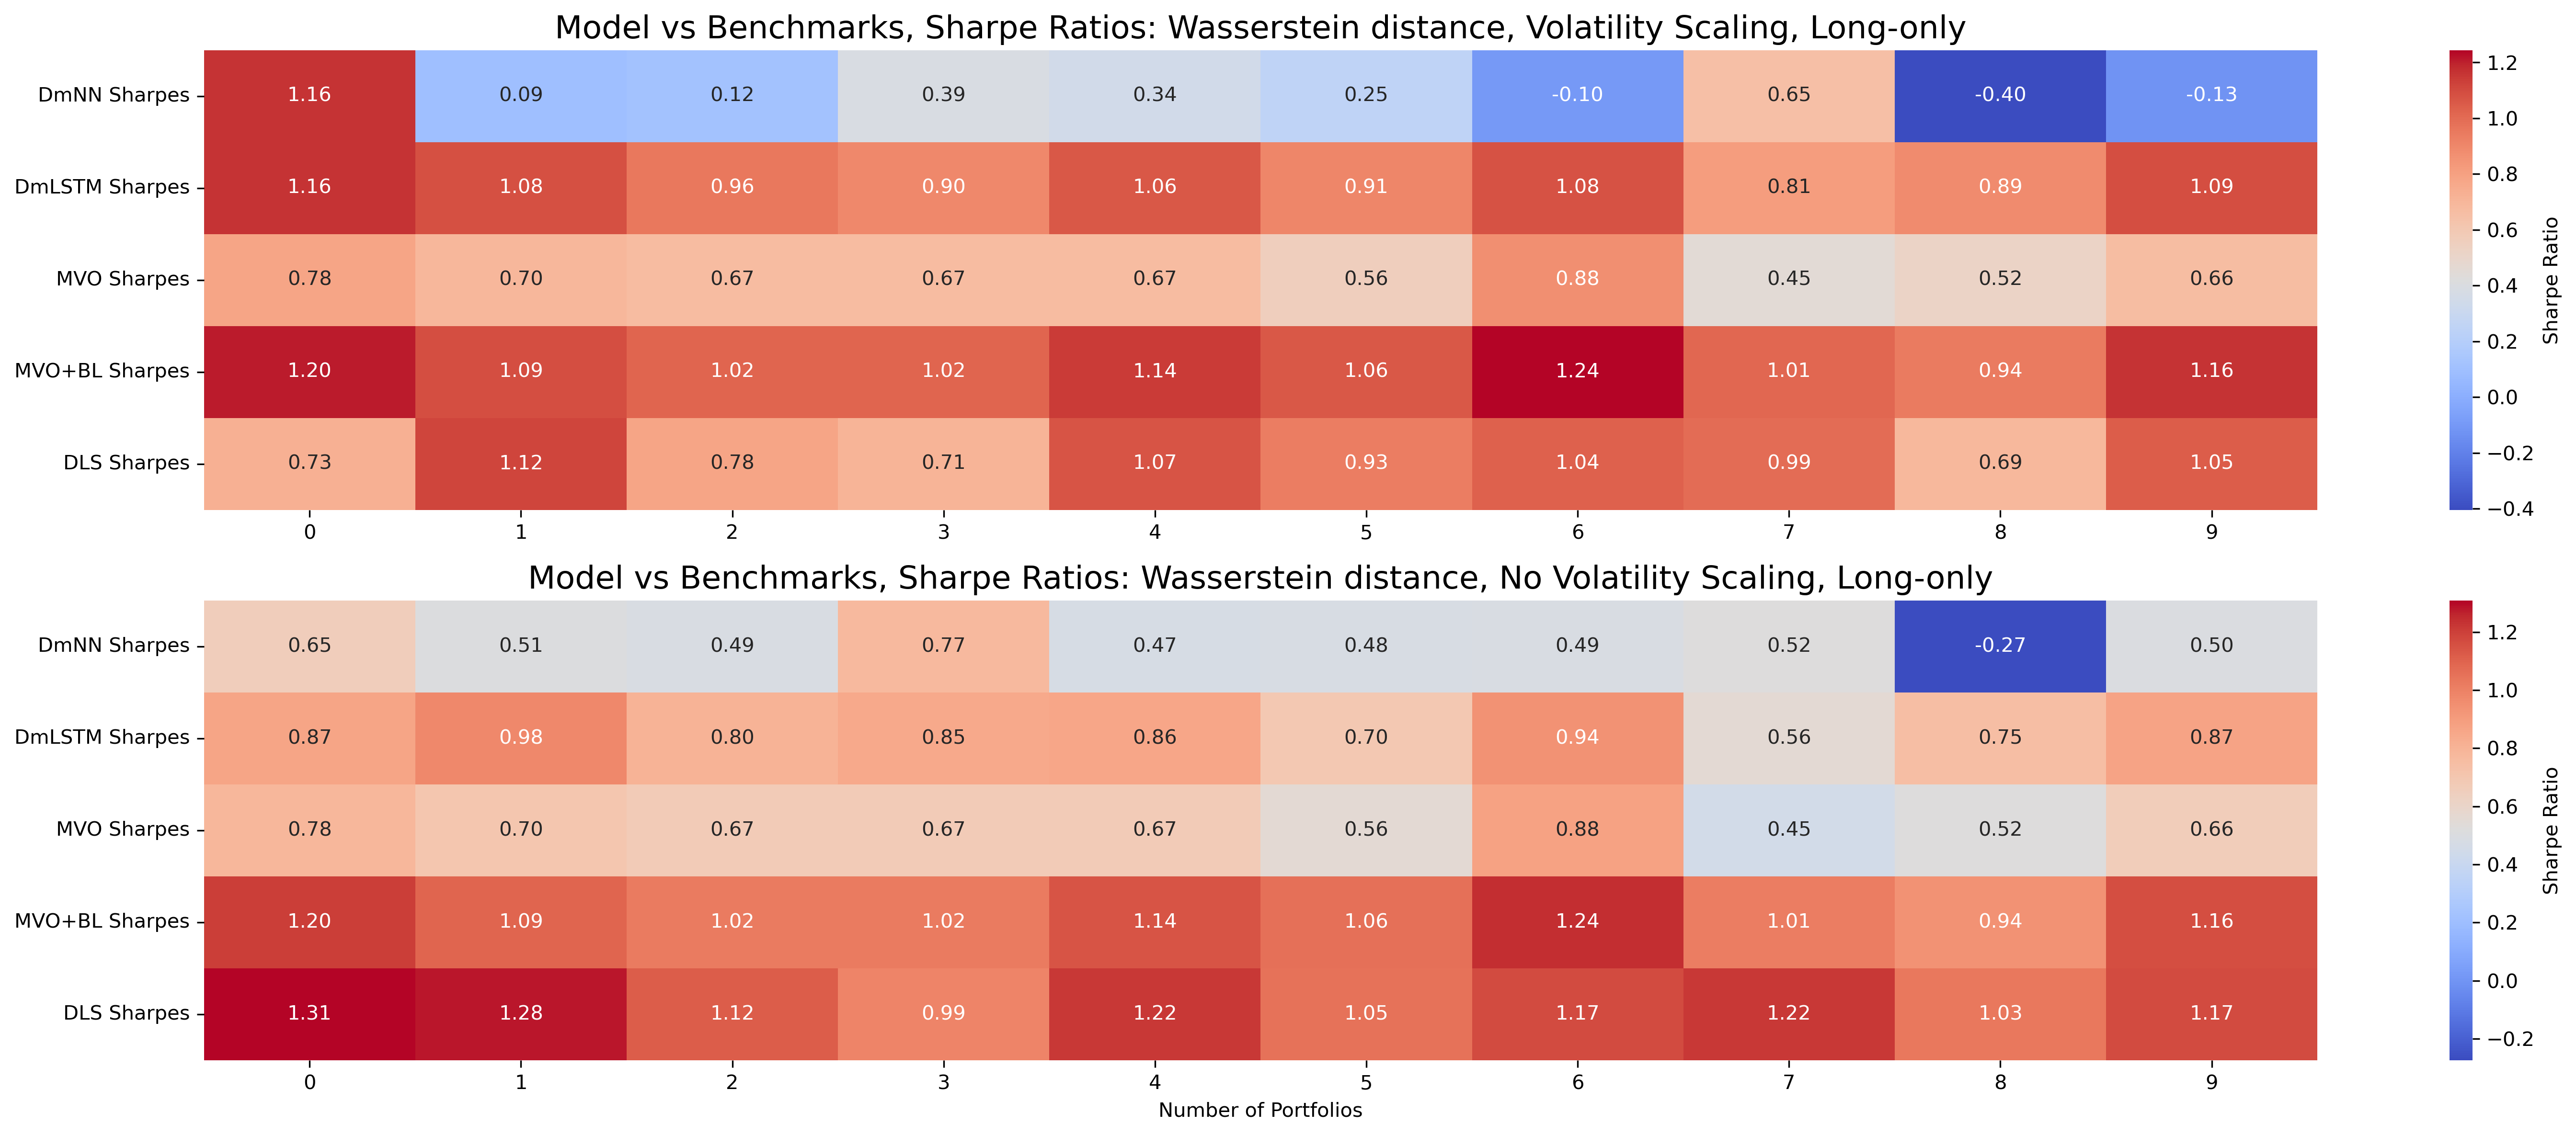

In [51]:
# Create one big figure with multiple heatmaps
fig, axes = plt.subplots(2, 1, figsize=(20, 8), dpi = 300)
data1 = validation_VS.loc[:, ["DmNN Sharpes", "DmLSTM Sharpes", "MVO Sharpes", "MVO+BL Sharpes", "DLS Sharpes"]]
data2 = validation_noVS.loc[:, ["DmNN Sharpes", "DmLSTM Sharpes", "MVO Sharpes", "MVO+BL Sharpes", "DLS Sharpes"]]
create_heatmap(data1, axes[0], title = "Model vs Benchmarks, Sharpe Ratios: Wasserstein distance, Volatility Scaling, Long-only", label = "Sharpe Ratio")
create_heatmap(data2, axes[1], title = "Model vs Benchmarks, Sharpe Ratios: Wasserstein distance, No Volatility Scaling, Long-only", label = "Sharpe Ratio")
plt.xlabel('Number of Portfolios')
plt.tight_layout()
plt.show()

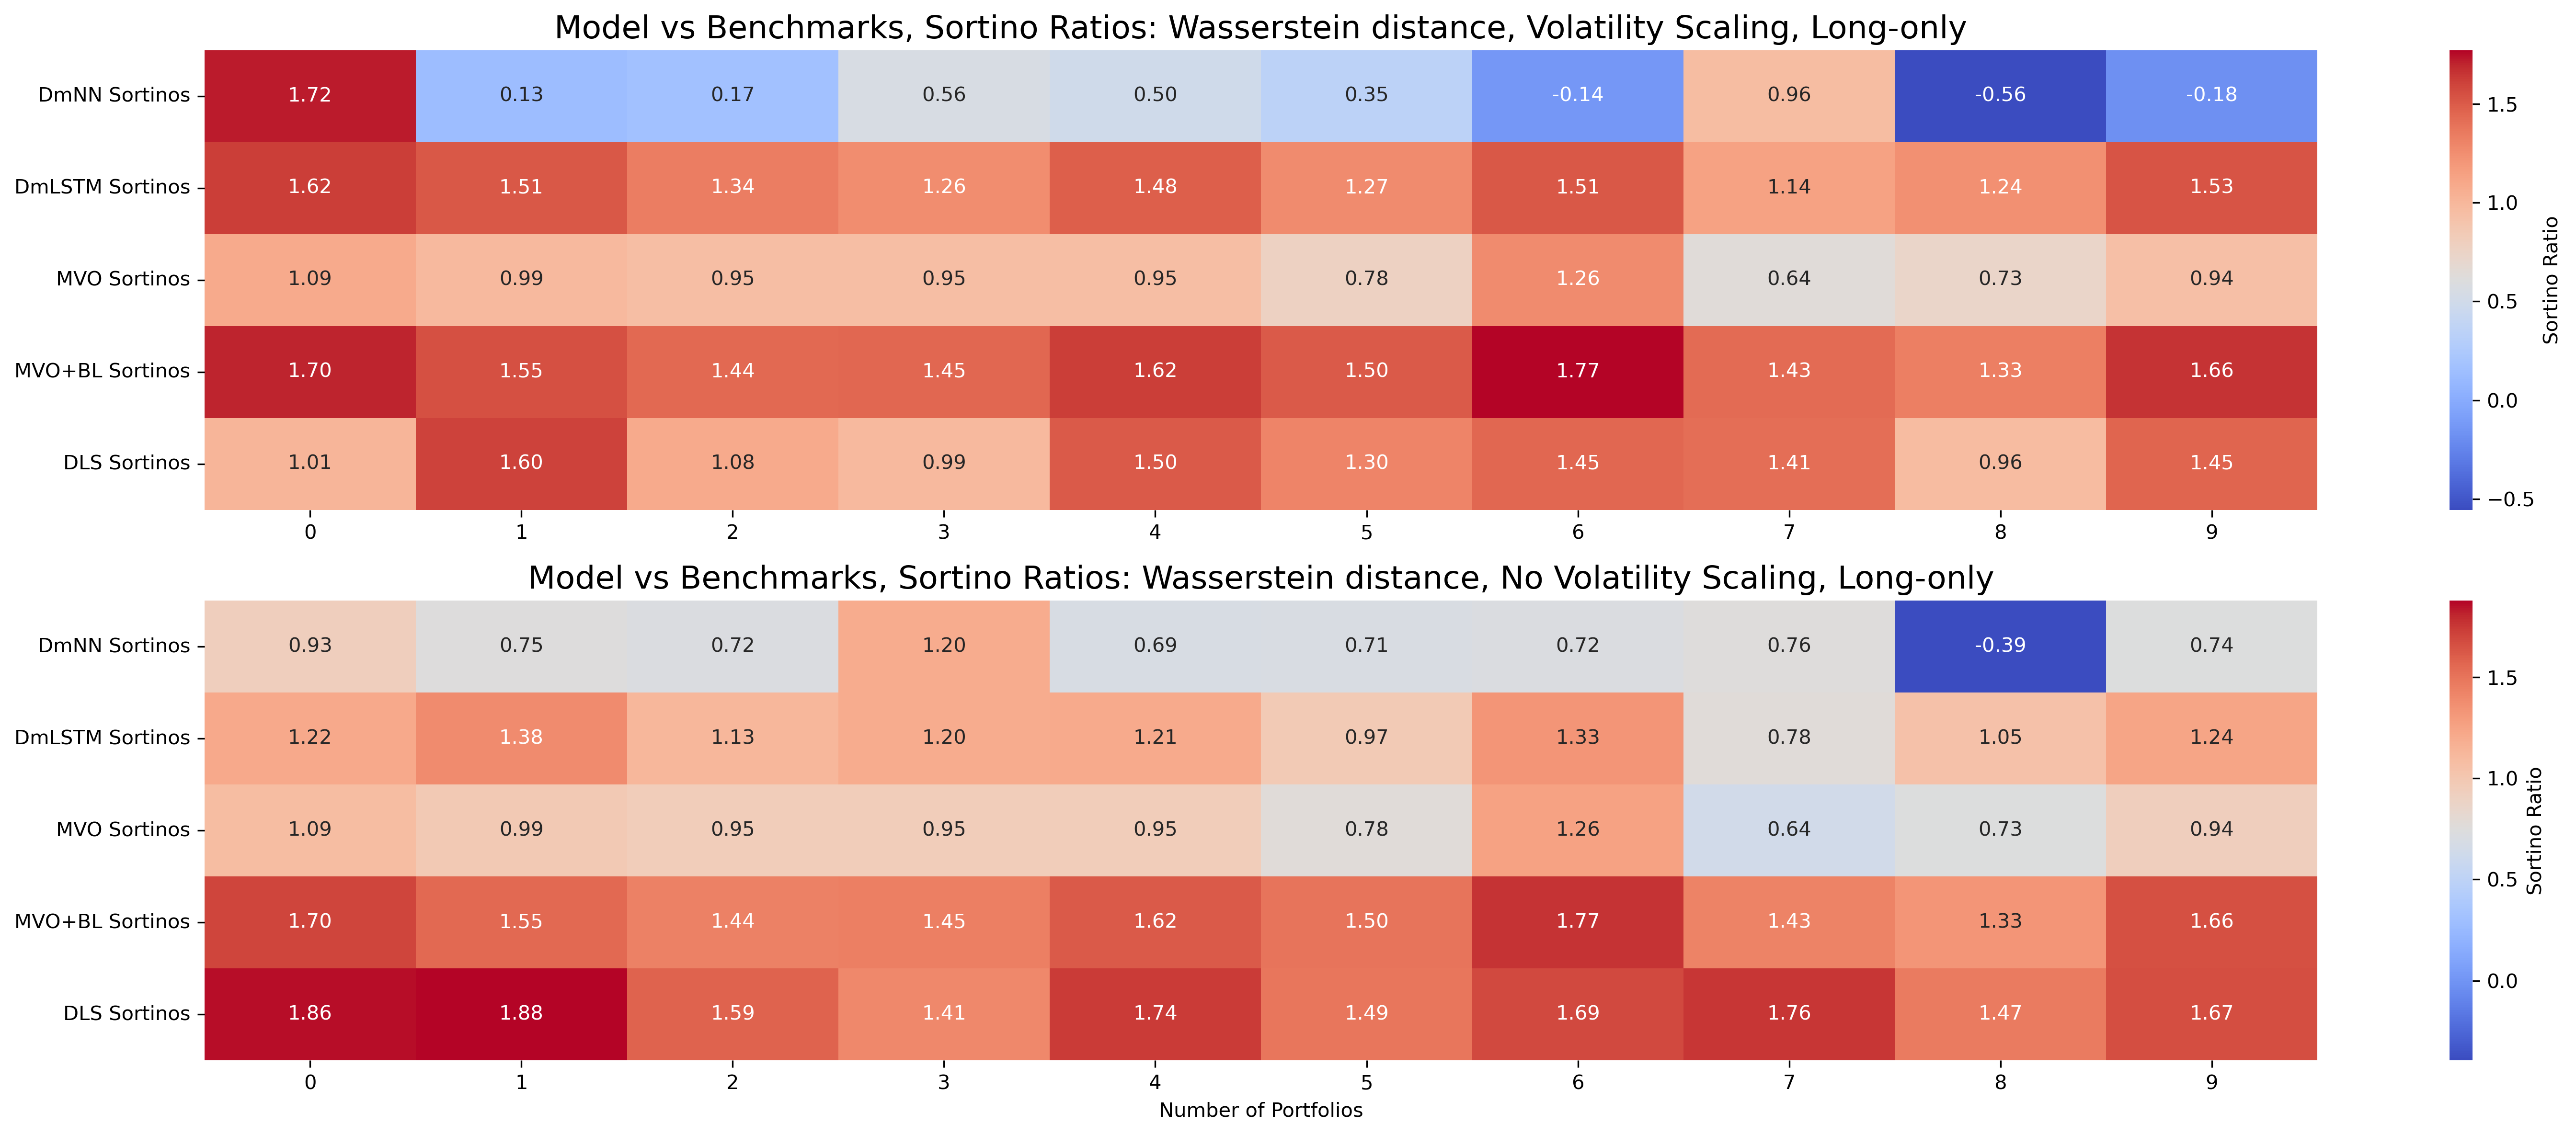

In [52]:
# Create one big figure with multiple heatmaps
fig, axes = plt.subplots(2, 1, figsize=(20, 8), dpi = 300)
data3 = validation_VS.loc[:, ["DmNN Sortinos", "DmLSTM Sortinos", "MVO Sortinos", "MVO+BL Sortinos", "DLS Sortinos"]]
data4 = validation_noVS.loc[:, ["DmNN Sortinos", "DmLSTM Sortinos", "MVO Sortinos", "MVO+BL Sortinos", "DLS Sortinos"]]
create_heatmap(data3, axes[0], title = "Model vs Benchmarks, Sortino Ratios: Wasserstein distance, Volatility Scaling, Long-only", label = "Sortino Ratio")
create_heatmap(data4, axes[1], title = "Model vs Benchmarks, Sortino Ratios: Wasserstein distance, No Volatility Scaling, Long-only", label = "Sortino Ratio")
plt.xlabel('Number of Portfolios')
plt.tight_layout()
plt.show()

Corerelation heatmap

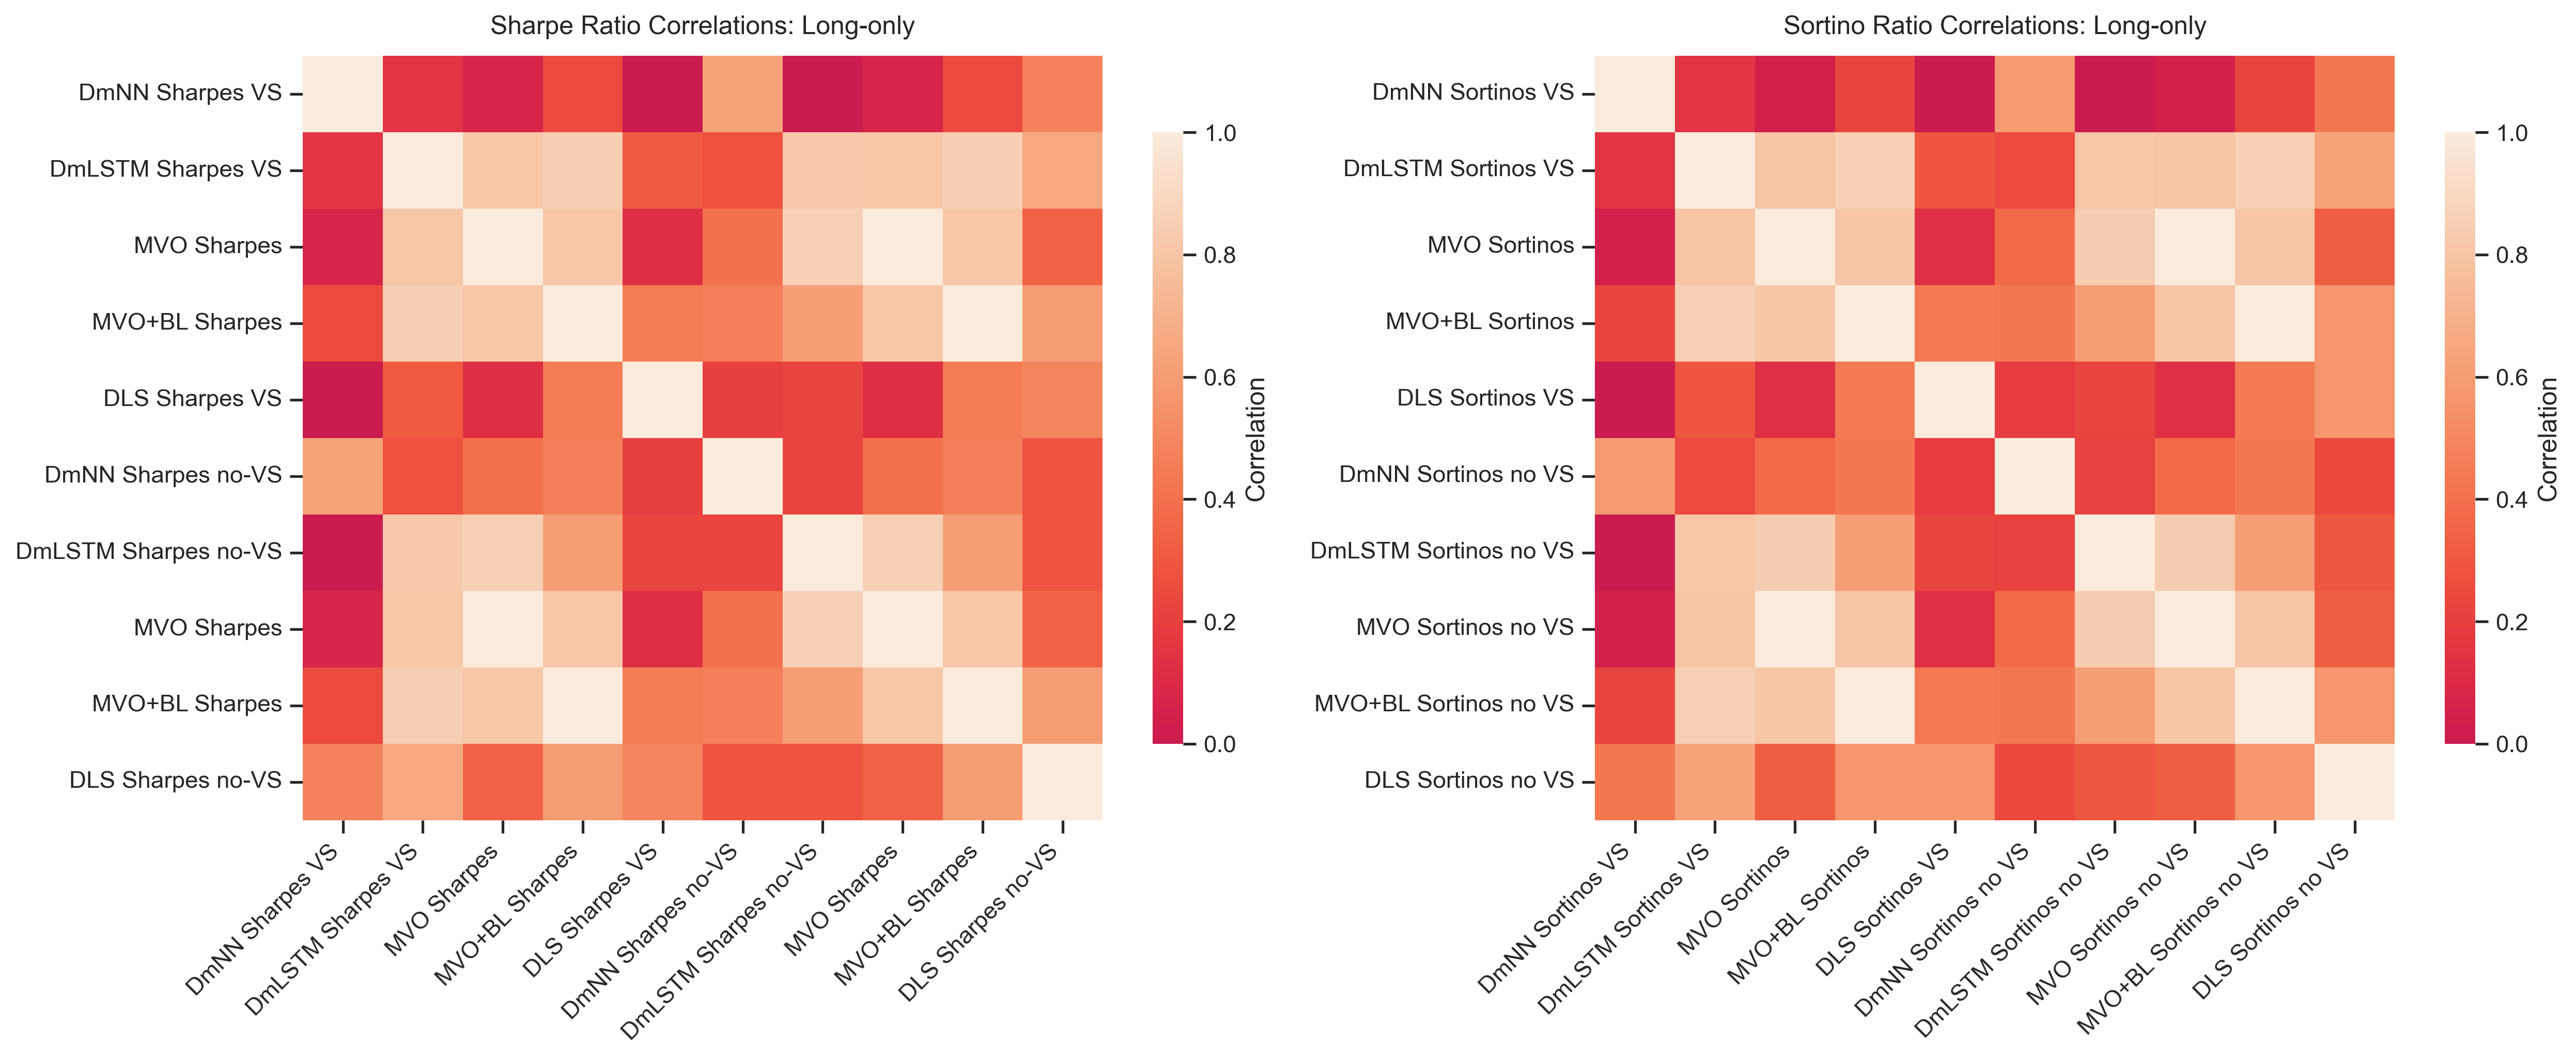

In [116]:
data1 = validation_VS.loc[:, ["DmNN Sharpes", "DmLSTM Sharpes", "MVO Sharpes", "MVO+BL Sharpes", "DLS Sharpes"]]  
data2 = validation_noVS.loc[:, ["DmNN Sharpes", "DmLSTM Sharpes", "MVO Sharpes", "MVO+BL Sharpes", "DLS Sharpes"]]
data1 = data1.rename(columns = {
    "DmNN Sharpes": "DmNN Sharpes VS", 
    "DmLSTM Sharpes": "DmLSTM Sharpes VS", 
    "DLS Sharpes": "DLS Sharpes VS"})
# Rename columns consistently
data2 = data2.rename(columns = {
    "DmNN Sharpes": "DmNN Sharpes no-VS", 
    "DmLSTM Sharpes": "DmLSTM Sharpes no-VS",  
    "DLS Sharpes": "DLS Sharpes no-VS"
})
data3 = data3.rename(columns = {
    "DmNN Sortinos": "DmNN Sortinos VS", 
    "DmLSTM Sortinos": "DmLSTM Sortinos VS", 
    "DLS Sortinos": "DLS Sortinos VS"})

data4 = data4.rename(columns = {
    "DmNN Sortinos": "DmNN Sortinos no-VS", 
    "DmLSTM Sortinos": "DmLSTM Sortinos no-VS", 
    "DLS Sortinos": "DLS Sortinos no-VS"
})
# Correlation matrices
corr_matrix_sharpes = pd.concat([data1, data2], axis=1).corr()
corr_matrix_sortinos = pd.concat([data3, data4], axis=1).corr()

# Subplots
fig, ax = plt.subplots(1, 2, figsize=(17, 7), dpi=300)
sns.set_theme(style="ticks")

# Heatmaps
sns.heatmap(
    corr_matrix_sharpes, annot=False, fmt=".2f", cmap="rocket", center=0,
    linewidths=0.5, linecolor="none", cbar_kws={"shrink": 0.8, "label": "Correlation"}, ax=ax[0], vmin = 0, vmax = 1
)
sns.heatmap(
    corr_matrix_sortinos, annot=False, fmt=".2f", cmap="rocket", center=0,
    linewidths=0.5, linecolor="none", cbar_kws={"shrink": 0.8, "label": "Correlation"}, ax=ax[1], vmin = 0, vmax = 1
)

# Titles
ax[0].set_title("Sharpe Ratio Correlations: Long-only", fontsize=12, pad=10)
ax[1].set_title("Sortino Ratio Correlations: Long-only", fontsize=12, pad=10)

# Rotate tick labels
for a in ax:
    a.set_xticklabels(a.get_xticklabels(), rotation=45, ha="right")
    a.set_yticklabels(a.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()


## P-values via Bootstrap DGP

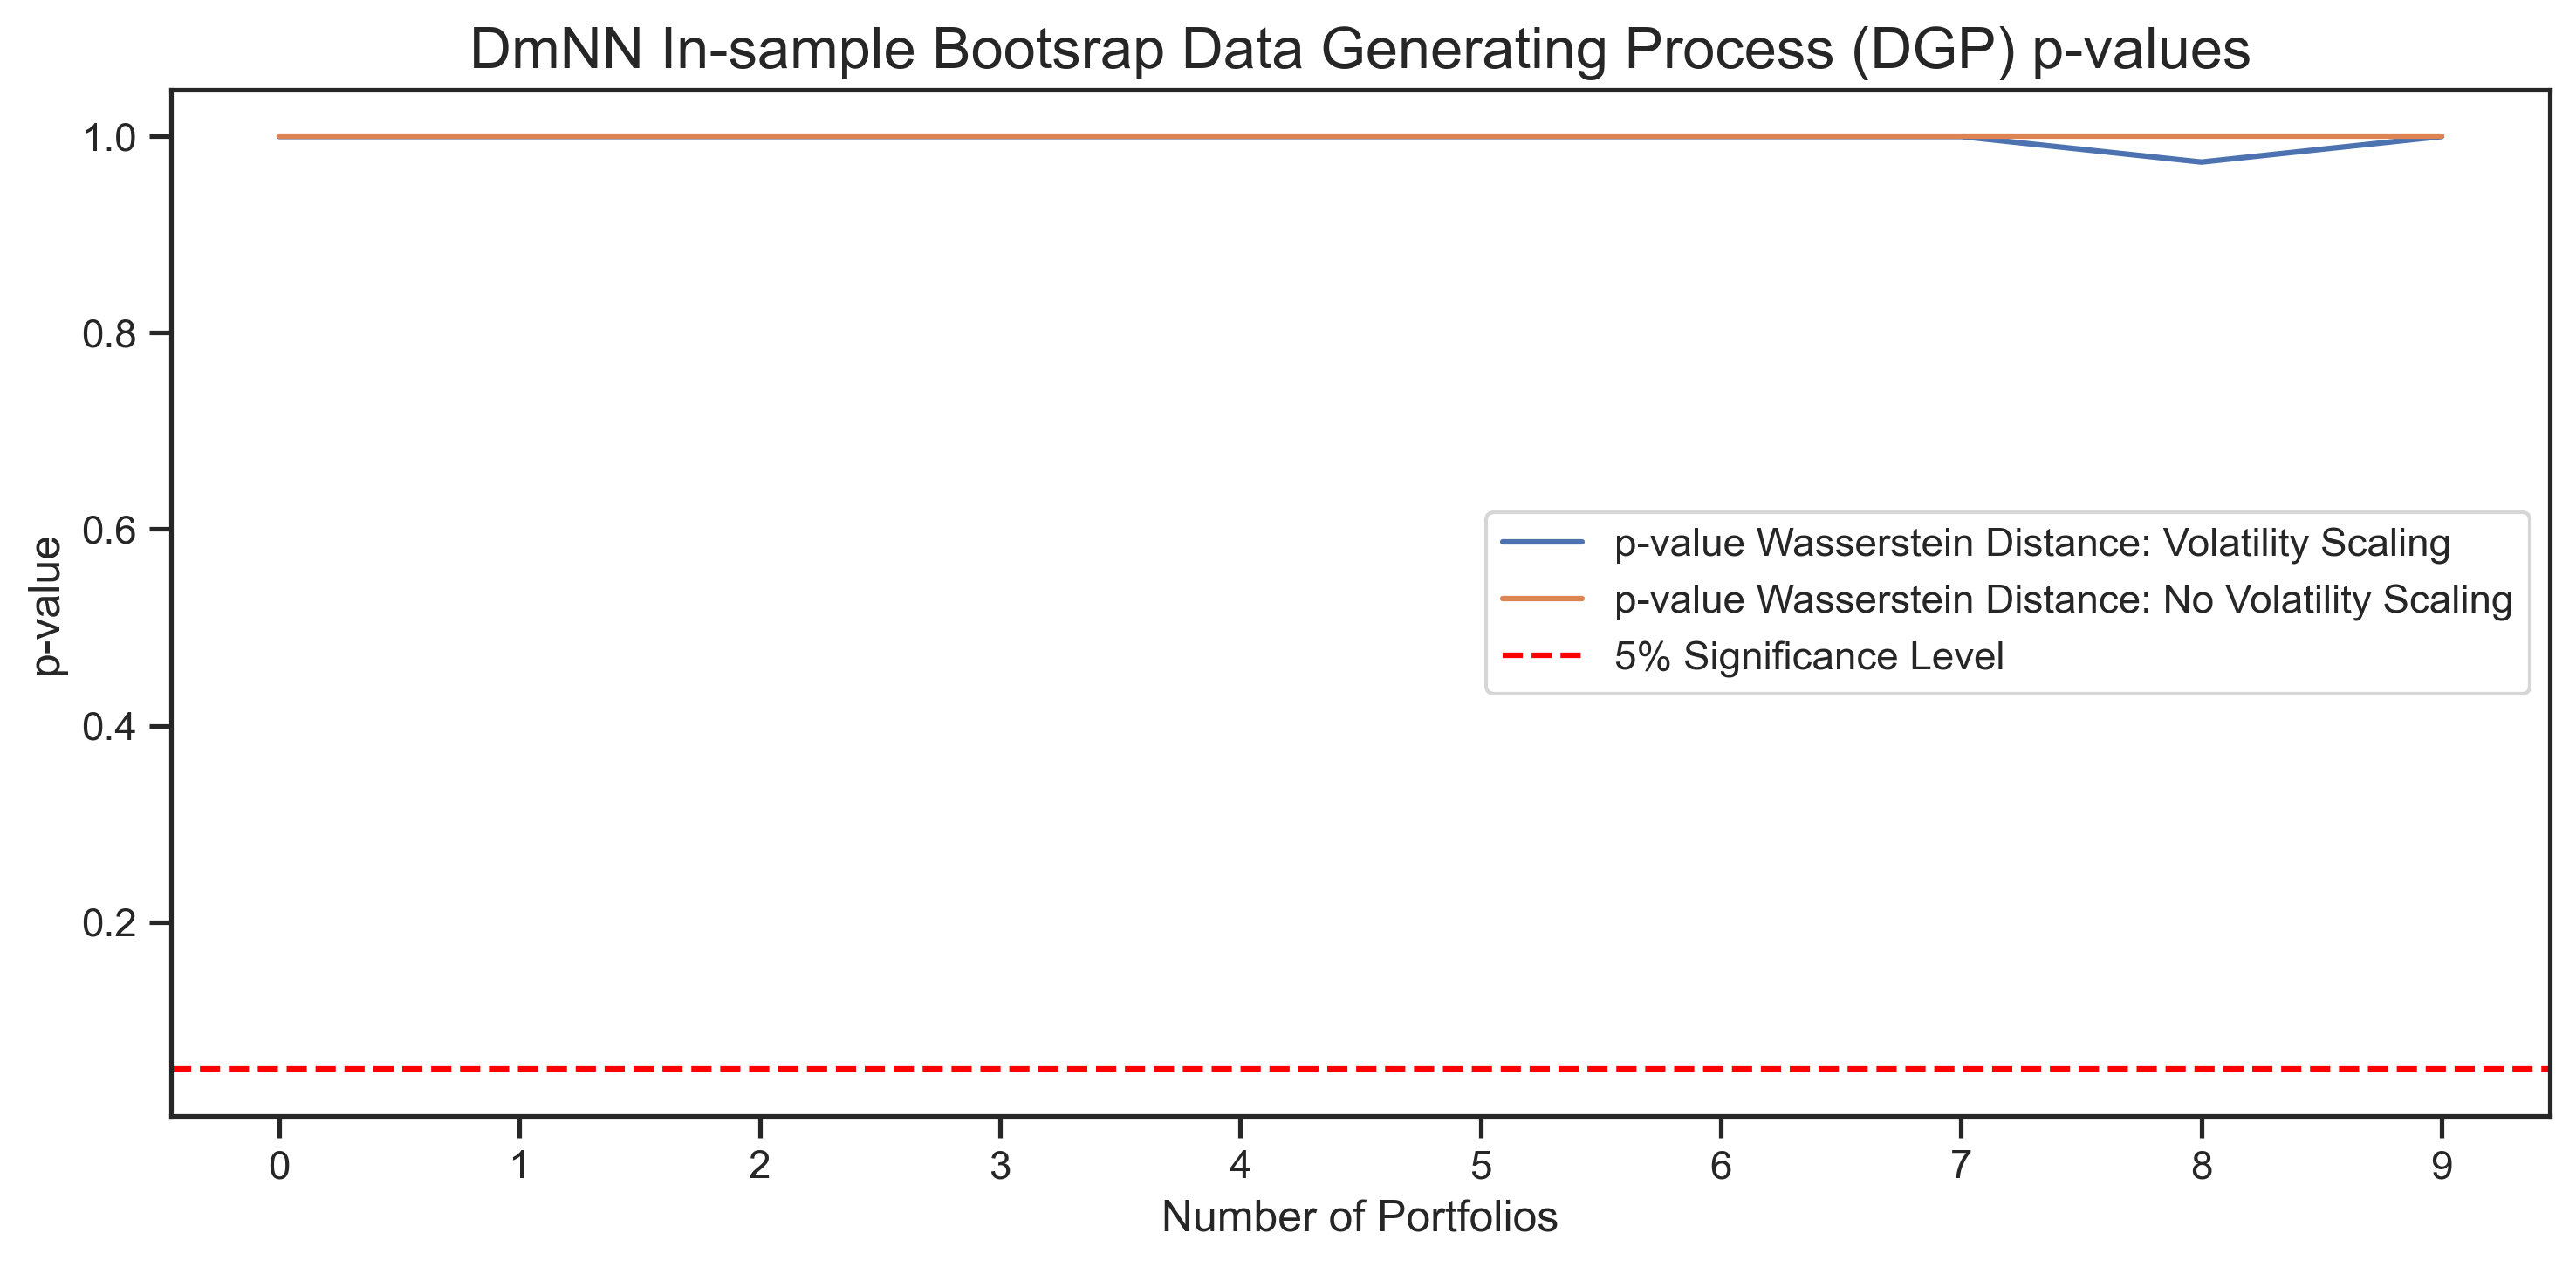

In [110]:
plt.figure(figsize = (10, 5), dpi = 300)
plt.plot(validation_VS["p-values"], label = "p-value Wasserstein Distance: Volatility Scaling")
plt.plot(validation_noVS["p-values"], label = "p-value Wasserstein Distance: No Volatility Scaling")
plt.axhline(y = 0.05, color = "red", linestyle = "--", label = f"{5}% Significance Level")
plt.title("DmNN In-sample Bootsrap Data Generating Process (DGP) p-values", fontsize = 16)
plt.xlabel("Days")
plt.ylabel("p-value")
plt.xlabel('Number of Portfolios')
plt.xticks(range(0, 10))
plt.tight_layout()
plt.legend()

## VaR and CVaR EDA 

In [68]:
var_vs = validation_VS.loc[
    :, 
    ["VaR Model", "VaR DmLSTM", "VaR MVO", "VaR MVO+BL", "VaR DLS"]
]
var_vs.to_csv("VaR_L_VS.csv", index=False)  

In [69]:
var_novs = validation_noVS.loc[
    :, 
    ["VaR Model", "VaR DmLSTM", "VaR MVO", "VaR MVO+BL", "VaR DLS"]
]
var_novs.to_csv("VaR_L_noVS.csv", index=False)  

In [70]:
cvar_vs = validation_VS.loc[
    :, 
    ["CVaR Model", "CVaR DmLSTM", "CVaR MVO", "CVaR MVO+BL", "CVaR DLS"]
]
cvar_vs.to_csv("CVaR_L_VS.csv", index=False)  

In [71]:
cvar_novs = validation_noVS.loc[
    :, 
    ["CVaR Model", "CVaR DmLSTM", "CVaR MVO", "CVaR MVO+BL", "CVaR DLS"]
]
cvar_novs.to_csv("CVaR_L_noVS.csv", index=False) 